In [ ]:
!pip install catboost pandas numpy scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.5 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

!mkdir -p ~/.kaggle

!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

# даем права доступа
!chmod 600 ~/.kaggle/kaggle.json

# скачиваем данные
!kaggle competitions download -c intern-regression-courier-deficit-challenge

# распаковываем
!unzip -o intern-regression-courier-deficit-challenge.zip -d data

print("Файлы находятся в папке data:")
print(os.listdir('data'))

Mounted at /content/drive
  0% 0.00/1.82M [00:00<?, ?B/s]
100% 1.82M/1.82M [00:00<00:00, 768MB/s]
Archive:  intern-regression-courier-deficit-challenge.zip
  inflating: data/facts.csv          
  inflating: data/sample_submission.csv  
  inflating: data/shifts_prediction.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          
Файлы находятся в папке data:
['test.csv', 'shifts_prediction.csv', 'sample_submission.csv', 'train.csv', 'facts.csv']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor

# удобное отображение
pd.set_option('display.max_columns', None)

# читаем данные
# parse_dates переводит текст в дату
train = pd.read_csv('data/train.csv', parse_dates=['calendar_dt'])
test = pd.read_csv('data/test.csv') # здесь даты нет
facts = pd.read_csv('data/facts.csv', parse_dates=['calendar_dt'])
shifts = pd.read_csv('data/shifts_prediction.csv', parse_dates=['calendar_dt'])
submission_example = pd.read_csv('data/sample_submission.csv')

print("Размеры таблиц:")
print(f"train: {train.shape}")
print(f"test: {test.shape}")
print(f"facts: {facts.shape}")
print(f"shifts: {shifts.shape}")

# смотрим на первые строки трейна
train.head()

Размеры таблиц:
train: (8220, 3)
test: (2438, 1)
facts: (10660, 13)
shifts: (223470, 5)


,calendar_dt,store_id,target
0,2025-11-03,000fade4-e8dc-11ed-b10a-08c0eb31fffb,1.0
1,2025-11-10,000fade4-e8dc-11ed-b10a-08c0eb31fffb,1.0
2,2025-11-17,000fade4-e8dc-11ed-b10a-08c0eb31fffb,4.0
3,2025-11-03,0022f1b0-b8f8-11ee-b10b-08c0eb31fffb,1.0
4,2025-11-10,0022f1b0-b8f8-11ee-b10b-08c0eb31fffb,1.0


In [ ]:
# добавляем дату в тест
test['calendar_dt'] = pd.to_datetime('2025-11-24')

# помечаем отдельно трейн и тест, чтобы потом разделить
train['is_train'] = 1
test['is_train'] = 0
test['target'] = np.nan # это мы будем предсказывать

# склеиваем в один длинный dataframe
df = pd.concat([train, test], ignore_index=True)

# добавляем в каждую строку информацию о прошлом (фактах) и будущем (прогнозах)
df = df.merge(facts, on=['store_id', 'calendar_dt'], how='left')
df = df.merge(shifts, on=['store_id', 'calendar_dt'], how='left')

print("размер общего датасета:", df.shape)
print("пропуски (только 5):")
print(df.isnull().sum().sort_values(ascending=False).head(5))

# заполним пропуски нулями (для начала)
# не заполняем target, он должен остаться NaN в тесте
features_to_fill = [c for c in df.columns if c != 'target']
df[features_to_fill] = df[features_to_fill].fillna(0)

размер общего датасета: (10658, 18)
пропуски (только 5):
marketing_costs_lag_1              3203
fact_percent_lateness_lag_1        2457
target                             2438
fact_load_factor_lag_1              115
fact_couriers_with_shifts_lag_1     115
dtype: int64


In [ ]:
# фичи из даты
df['month'] = df['calendar_dt'].dt.month
df['day'] = df['calendar_dt'].dt.day
# номер недели в году
df['week_of_year'] = df['calendar_dt'].dt.isocalendar().week.astype(int)

# разница между прогнозом заказов и фактом прошлой недели
df['orders_diff'] = df['predicted_num_orders'] - df['fact_num_orders_lag_1']

# нагрузка
df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']

# определяем списки колонок
categorical_features = ['store_id', 'city_nm'] # текстовые поля
drop_cols = ['calendar_dt', 'target', 'is_train'] # это не идет в обучение
feature_cols = [c for c in df.columns if c not in drop_cols]

print(f"всего признаков: {len(feature_cols)}")
print(feature_cols)

всего признаков: 20
['store_id', 'fact_staff_value_lag_1', 'fact_load_factor_lag_1', 'num_available_couriers_lag_1', 'fact_num_orders_lag_1', 'fact_percent_lateness_lag_1', 'city_nm', 'store_lifetime_in_days', 'fact_staff_churn', 'flag_high_load_lag_1', 'marketing_costs_lag_1', 'fact_couriers_with_shifts_lag_1', 'predicted_staff_value', 'predicted_num_orders', 'predicted_load_factor', 'month', 'day', 'week_of_year', 'orders_diff', 'load_diff']


In [ ]:
# разделяем обратно
X_train = df[df['is_train'] == 1][feature_cols]
y_train = df[df['is_train'] == 1]['target']
X_test = df[df['is_train'] == 0][feature_cols]

# инициализируем CatBoost
model = CatBoostRegressor(
    iterations=1500,          # количество деревьев (эпох)
    learning_rate=0.03,       # шаг обучения
    depth=6,                  # глубина дерева
    loss_function='MAE',      # оптимизируем среднюю абсолютную ошибку
    eval_metric='MAE',
    cat_features=categorical_features, # категориальные фичи
    random_seed=42,
    verbose=100               # вывод каждые 100 итераций
)

print("начинаем обучение...")
model.fit(X_train, y_train)
print("Готово!")

начинаем обучение...
0:	learn: 1.9121974	total: 55.3ms	remaining: 1m 22s
100:	learn: 0.4897663	total: 1.83s	remaining: 25.4s
200:	learn: 0.4348211	total: 4.74s	remaining: 30.6s
300:	learn: 0.4235268	total: 6.41s	remaining: 25.5s
400:	learn: 0.4120154	total: 8.94s	remaining: 24.5s
500:	learn: 0.4030597	total: 12.1s	remaining: 24.2s
600:	learn: 0.3927104	total: 14.2s	remaining: 21.2s
700:	learn: 0.3881858	total: 16.4s	remaining: 18.6s
800:	learn: 0.3828637	total: 18.4s	remaining: 16.1s
900:	learn: 0.3789922	total: 20.4s	remaining: 13.5s
1000:	learn: 0.3756024	total: 22.6s	remaining: 11.3s
1100:	learn: 0.3707492	total: 25.4s	remaining: 9.2s
1200:	learn: 0.3678933	total: 26.8s	remaining: 6.66s
1300:	learn: 0.3644926	total: 27.6s	remaining: 4.22s
1400:	learn: 0.3616904	total: 28.4s	remaining: 2.01s
1499:	learn: 0.3594796	total: 29.2s	remaining: 0us
Готово!


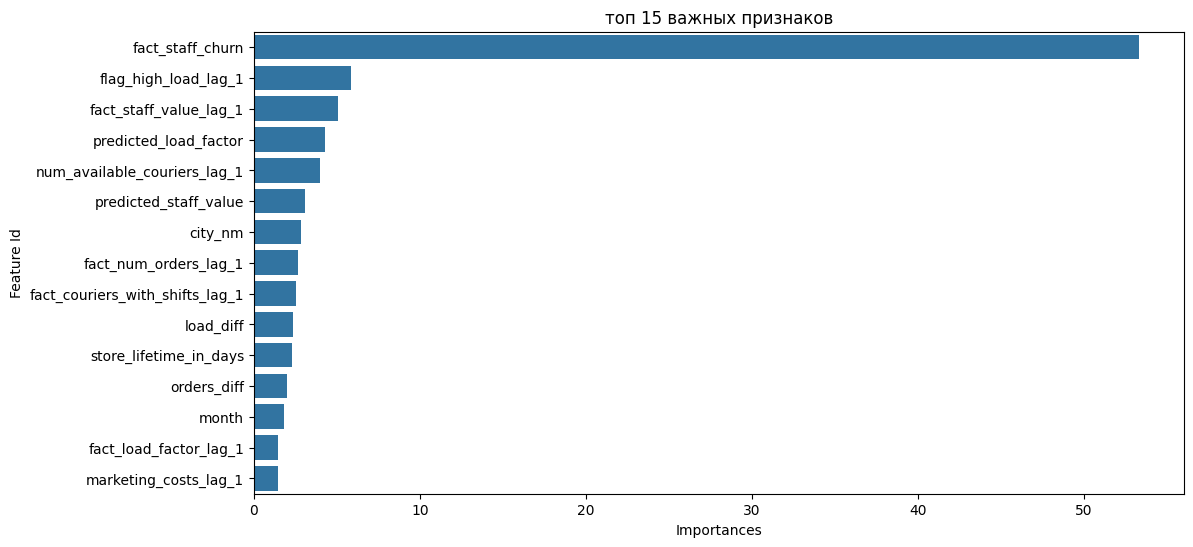

In [ ]:
# смотрим важность фич
feature_importance = model.get_feature_importance(prettified=True)
plt.figure(figsize=(12, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance.head(15))
plt.title('топ 15 важных признаков')
plt.show()

In [ ]:
predictions = model.predict(X_test)

# дефицит не может быть отрицательным.
predictions = np.maximum(predictions, 0)

# собираем DataFrame
submission = pd.DataFrame({
    'store_id': test['store_id'],
    'target': predictions
})

# сортируем по store_id
submission = submission.sort_values(by='store_id')

submission.to_csv('submission_v1_catboost.csv', index=False)

print("Файл сохранён!")

Файл сохранён!


In [ ]:
# соберем датасет заново, чтобы убрать заполнение нулями
# снова склеиваем
df_v2 = pd.concat([train, test], ignore_index=True)
df_v2 = df_v2.merge(facts, on=['store_id', 'calendar_dt'], how='left')
df_v2 = df_v2.merge(shifts, on=['store_id', 'calendar_dt'], how='left')

# заполним нулями только то, где это логично
df_v2['marketing_costs_lag_1'] = df_v2['marketing_costs_lag_1'].fillna(0)
df_v2['flag_high_load_lag_1'] = df_v2['flag_high_load_lag_1'].fillna(0)

# остальные колонки пока оставим как NaN

# новые фичи
# базовые даты
df_v2['month'] = df_v2['calendar_dt'].dt.month
df_v2['week_of_year'] = df_v2['calendar_dt'].dt.isocalendar().week.astype(int)

# отношение прогноза к факту
# 1e-5 чтобы не делить на ноль
df_v2['orders_growth'] = df_v2['predicted_num_orders'] / (df_v2['fact_num_orders_lag_1'] + 1e-5)

# сколько уволилось относительно общего штата
df_v2['churn_rate'] = df_v2['fact_staff_churn'] / (df_v2['fact_staff_value_lag_1'] + 1e-5)

# разница между тем, сколько надо было и сколько было
df_v2['staff_shortage_lag'] = df_v2['fact_staff_value_lag_1'] - df_v2['fact_couriers_with_shifts_lag_1']

# старые полезные фичи
df_v2['orders_diff'] = df_v2['predicted_num_orders'] - df_v2['fact_num_orders_lag_1']
df_v2['load_diff'] = df_v2['predicted_load_factor'] - df_v2['fact_load_factor_lag_1']


categorical_features = ['store_id', 'city_nm']
drop_cols = ['calendar_dt', 'target', 'is_train']
feature_cols = [c for c in df_v2.columns if c not in drop_cols]

print(f"новые фичи добавлены, всего: {len(feature_cols)}")

X_train_v2 = df_v2[df_v2['is_train'] == 1][feature_cols]
y_train_v2 = df_v2[df_v2['is_train'] == 1]['target']
X_test_v2 = df_v2[df_v2['is_train'] == 0][feature_cols]

model_v2 = CatBoostRegressor(
    iterations=2000,          # больше деревьев
    learning_rate=0.02,       # меньше шаг
    depth=7,                  # чуть-чуть углубили дерево
    l2_leaf_reg=3,            # чтобы не переобучиться на churn
    loss_function='MAE',
    eval_metric='MAE',
    cat_features=categorical_features,
    nan_mode='Min',           # NaN считать меньше минимума
    random_seed=42,
    verbose=200
)

print("Обучаем модель v2...")
model_v2.fit(X_train_v2, y_train_v2)

preds_v2 = model_v2.predict(X_test_v2)
preds_v2 = np.maximum(preds_v2, 0) # чтобы убрать отрицательные

submission_v2 = pd.DataFrame({
    'store_id': test['store_id'], # id берем из исходного теста
    'target': preds_v2
})
submission_v2 = submission_v2.sort_values(by='store_id')
submission_v2.to_csv('submission_v2_smart_nan.csv', index=False)

print("Готово! Файл создан")

новые фичи добавлены, всего: 22
Обучаем модель v2...
0:	learn: 1.9295076	total: 26.7ms	remaining: 53.3s
200:	learn: 0.4499014	total: 2.81s	remaining: 25.2s
400:	learn: 0.4157704	total: 5.36s	remaining: 21.4s
600:	learn: 0.3967554	total: 9.73s	remaining: 22.7s
800:	learn: 0.3793959	total: 12.5s	remaining: 18.7s
1000:	learn: 0.3721424	total: 15.6s	remaining: 15.6s
1200:	learn: 0.3631828	total: 18.5s	remaining: 12.3s
1400:	learn: 0.3555950	total: 23.5s	remaining: 10s
1600:	learn: 0.3494877	total: 26.5s	remaining: 6.6s
1800:	learn: 0.3439905	total: 29.4s	remaining: 3.25s
1999:	learn: 0.3389969	total: 32.2s	remaining: 0us
Готово! Файл создан


In [ ]:
# обновленная сборка
df_v3 = pd.concat([train, test], ignore_index=True)
df_v3 = df_v3.merge(facts, on=['store_id', 'calendar_dt'], how='left')
df_v3 = df_v3.merge(shifts, on=['store_id', 'calendar_dt'], how='left')

# работа с NaN как в прошлой версии
df_v3['marketing_costs_lag_1'] = df_v3['marketing_costs_lag_1'].fillna(0)
df_v3['flag_high_load_lag_1'] = df_v3['flag_high_load_lag_1'].fillna(0)

# прогноз дефицита: сколько надо по прогнозу - сколько выходило на прошлой неделе
df_v3['heuristic_diff'] = df_v3['predicted_staff_value'] - df_v3['fact_couriers_with_shifts_lag_1']

# насколько вырос план по заказам относительно факта
df_v3['orders_increase_ratio'] = df_v3['predicted_num_orders'] / (df_v3['fact_num_orders_lag_1'] + 1)

# остальные полезные фичи
df_v3['month'] = df_v3['calendar_dt'].dt.month
df_v3['week_of_year'] = df_v3['calendar_dt'].dt.isocalendar().week.astype(int)
df_v3['churn_ratio'] = df_v3['fact_staff_churn'] / (df_v3['fact_staff_value_lag_1'] + 1)

# проверяем  перед отправкой
print("запуск локальной валидации")

# определяем фичи
drop_cols = ['calendar_dt', 'target', 'is_train']
features = [c for c in df_v3.columns if c not in drop_cols]
cat_features = ['store_id', 'city_nm']

# берем только тренировочные данные
train_full = df_v3[df_v3['is_train'] == 1].copy()

# отрезаем последнюю доступную дату в train для проверки
last_date = train_full['calendar_dt'].max()
print(f"дата для проверки: {last_date}")

X_train_local = train_full[train_full['calendar_dt'] < last_date][features]
y_train_local = train_full[train_full['calendar_dt'] < last_date]['target']

X_val_local = train_full[train_full['calendar_dt'] == last_date][features]
y_val_local = train_full[train_full['calendar_dt'] == last_date]['target']

# обучаем проверочную модель
val_model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.03,
    depth=6,
    cat_features=cat_features,
    loss_function='MAE',
    verbose=200,
    random_seed=42
)
val_model.fit(X_train_local, y_train_local)

# проверяем качество
preds_val = val_model.predict(X_val_local)
preds_val = np.maximum(preds_val, 0) # убираем отрицательные

# считаем WAPE по формуле
wape = np.sum(np.abs(y_val_local - preds_val)) / np.sum(np.abs(y_val_local))
print(f"ЛОКАЛЬНЫЙ WAPE: {wape:.5f}")

запуск локальной валидации
дата для проверки: 2025-11-17 00:00:00
0:	learn: 1.9036886	total: 13.1ms	remaining: 19.7s
200:	learn: 0.4241836	total: 1.54s	remaining: 9.93s
400:	learn: 0.3956460	total: 4.31s	remaining: 11.8s
600:	learn: 0.3713680	total: 6.85s	remaining: 10.3s
800:	learn: 0.3571895	total: 8.54s	remaining: 7.45s
1000:	learn: 0.3465110	total: 10.1s	remaining: 5.05s
1200:	learn: 0.3391874	total: 11.8s	remaining: 2.92s
1400:	learn: 0.3325068	total: 13.3s	remaining: 939ms
1499:	learn: 0.3297866	total: 14.1s	remaining: 0us
ЛОКАЛЬНЫЙ WAPE: 0.18200


In [ ]:
# копируем датасет из прошлой версии
df_v4 = df_v3.copy()

# считаем средний дефицит для каждого магазина по трейну
store_history = train.groupby('store_id')['target'].mean().reset_index()
store_history.columns = ['store_id', 'store_mean_deficit']

# приклеиваем это знание ко всему датасету
df_v4 = df_v4.merge(store_history, on='store_id', how='left')

# если магазин новый и нет его истории заполняем общим средним по всем магазинам
global_mean = train['target'].mean()
df_v4['store_mean_deficit'] = df_v4['store_mean_deficit'].fillna(global_mean)

# считаем средний процент опозданий в каждом городе
city_stats = df_v4.groupby('city_nm')['fact_percent_lateness_lag_1'].transform('mean')
df_v4['city_mean_lateness'] = city_stats

# сколько заказов приходится на одного курьера, который предложил услуги
# +1 чтобы не делить на ноль
df_v4['orders_per_available_courier'] = df_v4['predicted_num_orders'] / (df_v4['num_available_couriers_lag_1'] + 1)

print("проверка версии v4")

features_v4 = features + ['store_mean_deficit', 'city_mean_lateness', 'orders_per_available_courier']
print(f"количество фич: {len(features_v4)}")

# делим на трейн и валидацию по времени
train_full = df_v4[df_v4['is_train'] == 1].copy()
last_date = train_full['calendar_dt'].max()

X_train_local = train_full[train_full['calendar_dt'] < last_date][features_v4]
y_train_local = train_full[train_full['calendar_dt'] < last_date]['target']

X_val_local = train_full[train_full['calendar_dt'] == last_date][features_v4]
y_val_local = train_full[train_full['calendar_dt'] == last_date]['target']

# обучаем
model_v4_test = CatBoostRegressor(
    iterations=2000,          # чуть больше итераций
    learning_rate=0.03,
    depth=6,
    cat_features=cat_features,
    loss_function='MAE',
    verbose=200,
    random_seed=42
)
model_v4_test.fit(X_train_local, y_train_local)

# проверяем WAPE
preds_val_v4 = model_v4_test.predict(X_val_local)
preds_val_v4 = np.maximum(preds_val_v4, 0)
wape_v4 = np.sum(np.abs(y_val_local - preds_val_v4)) / np.sum(np.abs(y_val_local))

print(f"ЛОКАЛЬНЫЙ WAPE V4: {wape_v4:.5f}")
print(f"(прошлый результат 0.18200)")

проверка версии v4
количество фич: 23
0:	learn: 1.8973576	total: 35.7ms	remaining: 1m 11s
200:	learn: 0.3999850	total: 2.7s	remaining: 24.2s
400:	learn: 0.3523955	total: 4.41s	remaining: 17.6s
600:	learn: 0.3261400	total: 6.06s	remaining: 14.1s
800:	learn: 0.3167267	total: 7.73s	remaining: 11.6s
1000:	learn: 0.3074254	total: 9.47s	remaining: 9.45s
1200:	learn: 0.3007418	total: 11.2s	remaining: 7.43s
1400:	learn: 0.2946388	total: 14.5s	remaining: 6.18s
1600:	learn: 0.2890979	total: 16.8s	remaining: 4.19s
1800:	learn: 0.2846418	total: 18.5s	remaining: 2.04s
1999:	learn: 0.2802278	total: 20.2s	remaining: 0us
ЛОКАЛЬНЫЙ WAPE V4: 0.16966
(прошлый результат 0.18200)


In [ ]:
# обучение на всех данных

# берем фичи которые дали 0.169
features_v4 = features + ['store_mean_deficit', 'city_mean_lateness', 'orders_per_available_courier']
print(f"обучим модель на {len(features_v4)} признаках")

# берем весь трейн
X_train_full_v4 = df_v4[df_v4['is_train'] == 1][features_v4]
y_train_full_v4 = df_v4[df_v4['is_train'] == 1]['target']
X_test_final_v4 = df_v4[df_v4['is_train'] == 0][features_v4]

# инициализируем модель
model_v4 = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    cat_features=cat_features,
    loss_function='MAE',
    verbose=200,
    random_seed=42
)

# обучаем
model_v4.fit(X_train_full_v4, y_train_full_v4)

# предсказываем
final_preds_v4 = model_v4.predict(X_test_final_v4)
final_preds_v4 = np.maximum(final_preds_v4, 0) # уберем отрицательные

# сохраняем
submission_v4 = pd.DataFrame({
    'store_id': test['store_id'],
    'target': final_preds_v4
})
submission_v4 =submission_v4.sort_values(by='store_id')
submission_v4.to_csv('submission_v4_history.csv', index=False)

print("Файл готов!")

обучим модель на 23 признаках
0:	learn: 1.9153434	total: 28.9ms	remaining: 57.8s
200:	learn: 0.4009222	total: 2.02s	remaining: 18.1s
400:	learn: 0.3668331	total: 5.13s	remaining: 20.5s
600:	learn: 0.3473226	total: 8.18s	remaining: 19s
800:	learn: 0.3378854	total: 10.4s	remaining: 15.5s
1000:	learn: 0.3300461	total: 12.4s	remaining: 12.4s
1200:	learn: 0.3238339	total: 14.5s	remaining: 9.63s
1400:	learn: 0.3179766	total: 16.6s	remaining: 7.1s
1600:	learn: 0.3131660	total: 20.9s	remaining: 5.22s
1800:	learn: 0.3086650	total: 23s	remaining: 2.54s
1999:	learn: 0.3041562	total: 25.1s	remaining: 0us
Файл готов!


In [ ]:
# берем чистый датасет как в V3
df_v5 = pd.concat([train, test], ignore_index=True)
df_v5 = df_v5.merge(facts, on=['store_id', 'calendar_dt'], how='left')
df_v5 = df_v5.merge(shifts, on=['store_id', 'calendar_dt'], how='left')

# обработка пропусков
df_v5['marketing_costs_lag_1'] = df_v5['marketing_costs_lag_1'].fillna(0)
df_v5['flag_high_load_lag_1'] = df_v5['flag_high_load_lag_1'].fillna(0)

# те фичи, что сработали в V3 + одна новая

# V3
df_v5['heuristic_diff'] = df_v5['predicted_staff_value'] - df_v5['fact_couriers_with_shifts_lag_1']
df_v5['orders_increase_ratio'] = df_v5['predicted_num_orders'] / (df_v5['fact_num_orders_lag_1'] + 1)
df_v5['churn_ratio'] = df_v5['fact_staff_churn'] / (df_v5['fact_staff_value_lag_1'] + 1)

# считаем среднее опоздание в городе зная facts
df_v5['city_lateness_lag'] = df_v5.groupby('city_nm')['fact_percent_lateness_lag_1'].transform('median')

# дата
df_v5['month'] = df_v5['calendar_dt'].dt.month
df_v5['week_of_year'] = df_v5['calendar_dt'].dt.isocalendar().week.astype(int)

print("запуск валидации V5")

drop_cols = ['calendar_dt', 'target', 'is_train']
features_v5 = [c for c in df_v5.columns if c not in drop_cols]
cat_features = ['store_id', 'city_nm']

# делим
train_full = df_v5[df_v5['is_train'] == 1].copy()
last_date = train_full['calendar_dt'].max()

X_train_local = train_full[train_full['calendar_dt'] < last_date][features_v5]
y_train_local = train_full[train_full['calendar_dt'] < last_date]['target']

X_val_local = train_full[train_full['calendar_dt'] == last_date][features_v5]
y_val_local = train_full[train_full['calendar_dt'] == last_date]['target']

# параметры берем от V3
model_v5_val = CatBoostRegressor(
    iterations=1600,        # чуть добавили, тк фич больше
    learning_rate=0.03,
    depth=6,
    cat_features=cat_features,
    loss_function='MAE',
    verbose=200,
    random_seed=42
)
model_v5_val.fit(X_train_local, y_train_local)

# проверка
preds_val = model_v5_val.predict(X_val_local)
preds_val = np.maximum(preds_val, 0)
wape_v5 = np.sum(np.abs(y_val_local - preds_val)) / np.sum(np.abs(y_val_local))

print(f"WAPE V5: {wape_v5:.5f}")

запуск валидации V5
0:	learn: 1.8931542	total: 13.3ms	remaining: 21.3s
200:	learn: 0.4277359	total: 1.46s	remaining: 10.1s
400:	learn: 0.3942181	total: 2.97s	remaining: 8.89s
600:	learn: 0.3682781	total: 4.64s	remaining: 7.71s
800:	learn: 0.3558293	total: 6.24s	remaining: 6.22s
1000:	learn: 0.3454144	total: 9.74s	remaining: 5.83s
1200:	learn: 0.3367901	total: 12.6s	remaining: 4.18s
1400:	learn: 0.3297198	total: 14.2s	remaining: 2.01s
1599:	learn: 0.3231709	total: 16.3s	remaining: 0us
WAPE V5: 0.18348


In [ ]:
# V3 пока что лучшая версия

# собираем данные
df_final = pd.concat([train, test], ignore_index=True)
df_final = df_final.merge(facts, on=['store_id', 'calendar_dt'], how='left')
df_final = df_final.merge(shifts, on=['store_id', 'calendar_dt'], how='left')

# заполняем NaN
df_final['marketing_costs_lag_1'] = df_final['marketing_costs_lag_1'].fillna(0)
df_final['flag_high_load_lag_1'] = df_final['flag_high_load_lag_1'].fillna(0)

# только те фичи, что были в V3
df_final['heuristic_diff'] = df_final['predicted_staff_value'] - df_final['fact_couriers_with_shifts_lag_1']
# рост заказов
df_final['orders_increase_ratio'] = df_final['predicted_num_orders'] / (df_final['fact_num_orders_lag_1'] + 1)
# текучка кадров
df_final['churn_ratio'] = df_final['fact_staff_churn'] / (df_final['fact_staff_value_lag_1'] + 1)
# даты
df_final['month'] = df_final['calendar_dt'].dt.month
df_final['week_of_year'] = df_final['calendar_dt'].dt.isocalendar().week.astype(int)

# список фичей
features_final = ['store_id', 'fact_staff_value_lag_1', 'fact_load_factor_lag_1',
                  'num_available_couriers_lag_1', 'fact_num_orders_lag_1',
                  'fact_percent_lateness_lag_1', 'city_nm', 'store_lifetime_in_days',
                  'fact_staff_churn', 'flag_high_load_lag_1', 'marketing_costs_lag_1',
                  'fact_couriers_with_shifts_lag_1', 'predicted_staff_value',
                  'predicted_num_orders', 'predicted_load_factor', 'month',
                  'week_of_year', 'heuristic_diff', 'orders_increase_ratio', 'churn_ratio']
cat_features = ['store_id', 'city_nm']

# обучение на всем трейне
print("обучаем модель V3")
X_train = df_final[df_final['is_train'] == 1][features_final]
y_train = df_final[df_final['is_train'] == 1]['target']
X_test = df_final[df_final['is_train'] == 0][features_final]

model_v3_final = CatBoostRegressor(
    iterations=1600,
    learning_rate=0.03,
    depth=6,
    cat_features=cat_features,
    loss_function='MAE',
    verbose=200,
    random_seed=42
)
model_v3_final.fit(X_train, y_train)

# прогноз
preds = model_v3_final.predict(X_test)
preds = np.maximum(preds, 0)

# сохранение
sub = pd.DataFrame({'store_id': test['store_id'], 'target': preds})
sub = sub.sort_values(by='store_id')
sub.to_csv('submission_v3_final.csv', index=False)
print("Файл готов!")

обучаем модель V3
0:	learn: 1.9121974	total: 19.7ms	remaining: 31.4s
200:	learn: 0.4341427	total: 4.8s	remaining: 33.4s
400:	learn: 0.4111961	total: 6.64s	remaining: 19.9s
600:	learn: 0.3912670	total: 8.56s	remaining: 14.2s
800:	learn: 0.3797837	total: 10.6s	remaining: 10.5s
1000:	learn: 0.3712788	total: 12.7s	remaining: 7.61s
1200:	learn: 0.3649965	total: 16.4s	remaining: 5.46s
1400:	learn: 0.3594438	total: 19.2s	remaining: 2.72s
1599:	learn: 0.3543560	total: 21.3s	remaining: 0us
Файл готов!


In [ ]:
# собираем данные
df_check = pd.concat([train, test], ignore_index=True)
df_check = df_check.merge(facts, on=['store_id', 'calendar_dt'], how='left')
df_check = df_check.merge(shifts, on=['store_id', 'calendar_dt'], how='left')

# NaN
df_check['marketing_costs_lag_1'] = df_check['marketing_costs_lag_1'].fillna(0)
df_check['flag_high_load_lag_1'] = df_check['flag_high_load_lag_1'].fillna(0)

# фичи
df_check['heuristic_diff'] = df_check['predicted_staff_value'] - df_check['fact_couriers_with_shifts_lag_1']
df_check['orders_increase_ratio'] = df_check['predicted_num_orders'] / (df_check['fact_num_orders_lag_1'] + 1)
df_check['churn_ratio'] = df_check['fact_staff_churn'] / (df_check['fact_staff_value_lag_1'] + 1)
df_check['month'] = df_check['calendar_dt'].dt.month
df_check['week_of_year'] = df_check['calendar_dt'].dt.isocalendar().week.astype(int)

features_check = ['store_id', 'fact_staff_value_lag_1', 'fact_load_factor_lag_1',
                  'num_available_couriers_lag_1', 'fact_num_orders_lag_1',
                  'fact_percent_lateness_lag_1', 'city_nm', 'store_lifetime_in_days',
                  'fact_staff_churn', 'flag_high_load_lag_1', 'marketing_costs_lag_1',
                  'fact_couriers_with_shifts_lag_1', 'predicted_staff_value',
                  'predicted_num_orders', 'predicted_load_factor', 'month',
                  'week_of_year', 'heuristic_diff', 'orders_increase_ratio', 'churn_ratio']
cat_features = ['store_id', 'city_nm']

# делим на трейн и валидацию (последняя неделя)
train_full = df_check[df_check['is_train'] == 1].copy()
last_date = train_full['calendar_dt'].max()

X_train_local = train_full[train_full['calendar_dt'] < last_date][features_check]
y_train_local = train_full[train_full['calendar_dt'] < last_date]['target']

X_val_local = train_full[train_full['calendar_dt'] == last_date][features_check]
y_val_local = train_full[train_full['calendar_dt'] == last_date]['target']

# запускаем цикл
SEEDS = [42, 2023, 777, 1, 555]
val_preds_sum = np.zeros(len(X_val_local))
single_model_score = 0

print(f" сравним одиночную модель и ансамбль ({len(SEEDS)})")

for i, seed in enumerate(SEEDS):
    # обучаем
    model = CatBoostRegressor(
        iterations=1600, learning_rate=0.03, depth=6,
        cat_features=cat_features, loss_function='MAE',
        random_seed=seed, verbose=0, allow_writing_files=False
    )
    model.fit(X_train_local, y_train_local)

    # предсказываем
    p = model.predict(X_val_local)
    p = np.maximum(p, 0)

    # результат первого сида запомним отдельно
    if seed == 42:
        wape_single = np.sum(np.abs(y_val_local - p)) / np.sum(np.abs(y_val_local))
        print(f"Seed 42 (Single Model) WAPE: {wape_single:.5f}")
        single_model_score = wape_single

    val_preds_sum += p

# результат ансамбля
ensemble_preds = val_preds_sum / len(SEEDS)
wape_ensemble = np.sum(np.abs(y_val_local - ensemble_preds)) / np.sum(np.abs(y_val_local))

print(f"\nИТОГ:")
print(f"одиночная модель: {single_model_score:.5f}")
print(f"ансамбль (average): {wape_ensemble:.5f}")

diff = single_model_score - wape_ensemble
if diff > 0:
    print(f"ансамбль снизил ошибку на {diff:.5f}")
else:
    print(f"нет улучшения, ансамбль не помог")

 сравним одиночную модель и ансамбль (5
Seed 42 (Single Model) WAPE: 0.18148

ИТОГ:
одиночная модель: 0.18148
ансамбль (average): 0.18092
ансамбль снизил ошибку на 0.00056


In [ ]:
from sklearn.model_selection import KFold

# собираем базу
df_v7 = pd.concat([train, test], ignore_index=True)
df_v7 = df_v7.merge(facts, on=['store_id', 'calendar_dt'], how='left')
df_v7 = df_v7.merge(shifts, on=['store_id', 'calendar_dt'], how='left')
# NaN
df_v7['marketing_costs_lag_1'] = df_v7['marketing_costs_lag_1'].fillna(0)
df_v7['flag_high_load_lag_1'] = df_v7['flag_high_load_lag_1'].fillna(0)

# создаем колонку с NaN
df_v7['store_mean_deficit_kfold'] = np.nan

# работаем с трейном для обучения кодировщика
train_indices = df_v7[df_v7['is_train'] == 1].index
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ЦИКЛ ПО ФОЛДАМ
for train_idx, val_idx in kf.split(train_indices):
    # получаем индексы из общего датафрейма
    global_train_idx = train_indices[train_idx]
    global_val_idx = train_indices[val_idx]

    # считаем среднее на обучающей части фолда
    means = df_v7.loc[global_train_idx].groupby('store_id')['target'].mean()

    # применяем на валидационную часть
    df_v7.loc[global_val_idx, 'store_mean_deficit_kfold'] = df_v7.loc[global_val_idx, 'store_id'].map(means)

# Для теста берем среднее по всему трейну
global_means = df_v7[df_v7['is_train'] == 1].groupby('store_id')['target'].mean()
test_indices = df_v7[df_v7['is_train'] == 0].index
df_v7.loc[test_indices, 'store_mean_deficit_kfold'] = df_v7.loc[test_indices, 'store_id'].map(global_means)

# заполняем пропуски общим средним
df_v7['store_mean_deficit_kfold'] = df_v7['store_mean_deficit_kfold'].fillna(df_v7[df_v7['is_train']==1]['target'].mean())

# остальные фичи V3
df_v7['heuristic_diff'] = df_v7['predicted_staff_value'] - df_v7['fact_couriers_with_shifts_lag_1']
df_v7['orders_increase_ratio'] = df_v7['predicted_num_orders'] / (df_v7['fact_num_orders_lag_1'] + 1)
df_v7['churn_ratio'] = df_v7['fact_staff_churn'] / (df_v7['fact_staff_value_lag_1'] + 1)
df_v7['month'] = df_v7['calendar_dt'].dt.month
df_v7['week_of_year'] = df_v7['calendar_dt'].dt.isocalendar().week.astype(int)

# список фичей с новой крутой
features_v7 = ['store_id', 'fact_staff_value_lag_1', 'fact_load_factor_lag_1',
               'num_available_couriers_lag_1', 'fact_num_orders_lag_1',
               'fact_percent_lateness_lag_1', 'city_nm', 'store_lifetime_in_days',
               'fact_staff_churn', 'flag_high_load_lag_1', 'marketing_costs_lag_1',
               'fact_couriers_with_shifts_lag_1', 'predicted_staff_value',
               'predicted_num_orders', 'predicted_load_factor', 'month',
               'week_of_year', 'heuristic_diff', 'orders_increase_ratio', 'churn_ratio',
               'store_mean_deficit_kfold']

# локальная валидация V7
print("проверка V7")
train_full = df_v7[df_v7['is_train'] == 1].copy()
last_date = train_full['calendar_dt'].max()

X_train_local = train_full[train_full['calendar_dt'] < last_date][features_v7]
y_train_local = train_full[train_full['calendar_dt'] < last_date]['target']

X_val_local = train_full[train_full['calendar_dt'] == last_date][features_v7]
y_val_local = train_full[train_full['calendar_dt'] == last_date]['target']

# обучаем
model_v7 = CatBoostRegressor(
    iterations=2000, learning_rate=0.03, depth=6,
    cat_features=['store_id', 'city_nm'], loss_function='MAE',
    verbose=200, random_seed=42
)
model_v7.fit(X_train_local, y_train_local)

preds_v7 = model_v7.predict(X_val_local)
preds_v7 = np.maximum(preds_v7, 0)
wape_v7 = np.sum(np.abs(y_val_local - preds_v7)) / np.sum(np.abs(y_val_local))

print(f"WAPE V7: {wape_v7:.5f}")

проверка V7
0:	learn: 1.8919918	total: 12ms	remaining: 24.1s
200:	learn: 0.4166800	total: 1.55s	remaining: 13.9s
400:	learn: 0.3810636	total: 3.14s	remaining: 12.5s
600:	learn: 0.3530652	total: 7.18s	remaining: 16.7s
800:	learn: 0.3405362	total: 10.6s	remaining: 15.9s
1000:	learn: 0.3311268	total: 12.4s	remaining: 12.3s
1200:	learn: 0.3234823	total: 14s	remaining: 9.34s
1400:	learn: 0.3172832	total: 15.8s	remaining: 6.74s
1600:	learn: 0.3111965	total: 17.5s	remaining: 4.35s
1800:	learn: 0.3066405	total: 19.2s	remaining: 2.12s
1999:	learn: 0.3026059	total: 21.8s	remaining: 0us
WAPE V7: 0.18769


In [ ]:
# V8 подбор параметров

# собираем данные (как в V3)
df_tune = pd.concat([train, test], ignore_index=True)
df_tune = df_tune.merge(facts, on=['store_id', 'calendar_dt'], how='left')
df_tune = df_tune.merge(shifts, on=['store_id', 'calendar_dt'], how='left')

df_tune['marketing_costs_lag_1'] = df_tune['marketing_costs_lag_1'].fillna(0)
df_tune['flag_high_load_lag_1'] = df_tune['flag_high_load_lag_1'].fillna(0)

# фичи V3
df_tune['heuristic_diff'] = df_tune['predicted_staff_value'] - df_tune['fact_couriers_with_shifts_lag_1']
df_tune['orders_increase_ratio'] = df_tune['predicted_num_orders'] / (df_tune['fact_num_orders_lag_1'] + 1)
df_tune['churn_ratio'] = df_tune['fact_staff_churn'] / (df_tune['fact_staff_value_lag_1'] + 1)
df_tune['month'] = df_tune['calendar_dt'].dt.month
df_tune['week_of_year'] = df_tune['calendar_dt'].dt.isocalendar().week.astype(int)

# список фич
features_tune = ['store_id', 'fact_staff_value_lag_1', 'fact_load_factor_lag_1',
                 'num_available_couriers_lag_1', 'fact_num_orders_lag_1',
                 'fact_percent_lateness_lag_1', 'city_nm', 'store_lifetime_in_days',
                 'fact_staff_churn', 'flag_high_load_lag_1', 'marketing_costs_lag_1',
                 'fact_couriers_with_shifts_lag_1', 'predicted_staff_value',
                 'predicted_num_orders', 'predicted_load_factor', 'month',
                 'week_of_year', 'heuristic_diff', 'orders_increase_ratio', 'churn_ratio']
cat_features = ['store_id', 'city_nm']

# подготовка валидации (последняя неделя)
train_full = df_tune[df_tune['is_train'] == 1].copy()
last_date = train_full['calendar_dt'].max()

X_train_local = train_full[train_full['calendar_dt'] < last_date][features_tune]
y_train_local = train_full[train_full['calendar_dt'] < last_date]['target']

X_val_local = train_full[train_full['calendar_dt'] == last_date][features_tune]
y_val_local = train_full[train_full['calendar_dt'] == last_date]['target']

# ПЕРЕБОР ПАРАМЕТРОВ
depths = [4, 6, 8, 10]
lrs = [0.03, 0.05]

best_wape = 999
best_params = {}

print(f"поиск идеальных параметров")
print(f"базовый результат V3 был примерно 0.18148")

for d in depths:
    for lr in lrs:
        print(f"\nпроверяем: Depth = {d}, LR = {lr}")

        model = CatBoostRegressor(
            iterations=1500,
            learning_rate=lr,
            depth=d,
            cat_features=cat_features,
            loss_function='MAE',
            verbose=0, # Молчун
            random_seed=42,
            allow_writing_files=False
        )

        model.fit(X_train_local, y_train_local)

        preds = model.predict(X_val_local)
        preds = np.maximum(preds, 0)

        current_wape = np.sum(np.abs(y_val_local - preds)) / np.sum(np.abs(y_val_local))
        print(f"результат: {current_wape:.5f}")

        if current_wape < best_wape:
            best_wape = current_wape
            best_params = {'depth': d, 'learning_rate': lr}

print(f"\nЛУЧШИЙ РЕЗУЛЬТАТ: {best_wape:.5f}")
print(f"с параметрами: {best_params}")

поиск идеальных параметров
базовый результат V3 был примерно 0.18148

проверяем: Depth = 4, LR = 0.03
результат: 0.17582

проверяем: Depth = 4, LR = 0.05
результат: 0.18070

проверяем: Depth = 6, LR = 0.03
результат: 0.18033

проверяем: Depth = 6, LR = 0.05
результат: 0.18355

проверяем: Depth = 8, LR = 0.03
результат: 0.20174

проверяем: Depth = 8, LR = 0.05
результат: 0.19218

проверяем: Depth = 10, LR = 0.03
результат: 0.20051

проверяем: Depth = 10, LR = 0.05
результат: 0.20694

ЛУЧШИЙ РЕЗУЛЬТАТ: 0.17582
с параметрами: {'depth': 4, 'learning_rate': 0.03}


In [ ]:
# V9 с подходящими параметрами

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

# сборка данных
df_final = pd.concat([train, test], ignore_index=True)
df_final = df_final.merge(facts, on=['store_id', 'calendar_dt'], how='left')
df_final = df_final.merge(shifts, on=['store_id', 'calendar_dt'], how='left')

df_final['marketing_costs_lag_1'] = df_final['marketing_costs_lag_1'].fillna(0)
df_final['flag_high_load_lag_1'] = df_final['flag_high_load_lag_1'].fillna(0)

# фичи как в V3
df_final['heuristic_diff'] = df_final['predicted_staff_value'] - df_final['fact_couriers_with_shifts_lag_1']
df_final['orders_increase_ratio'] = df_final['predicted_num_orders'] / (df_final['fact_num_orders_lag_1'] + 1)
df_final['churn_ratio'] = df_final['fact_staff_churn'] / (df_final['fact_staff_value_lag_1'] + 1)
df_final['month'] = df_final['calendar_dt'].dt.month
df_final['week_of_year'] = df_final['calendar_dt'].dt.isocalendar().week.astype(int)

features_final = ['store_id', 'fact_staff_value_lag_1', 'fact_load_factor_lag_1',
                  'num_available_couriers_lag_1', 'fact_num_orders_lag_1',
                  'fact_percent_lateness_lag_1', 'city_nm', 'store_lifetime_in_days',
                  'fact_staff_churn', 'flag_high_load_lag_1', 'marketing_costs_lag_1',
                  'fact_couriers_with_shifts_lag_1', 'predicted_staff_value',
                  'predicted_num_orders', 'predicted_load_factor', 'month',
                  'week_of_year', 'heuristic_diff', 'orders_increase_ratio', 'churn_ratio']
cat_features = ['store_id', 'city_nm']

# подготовка
X_train = df_final[df_final['is_train'] == 1][features_final]
y_train = df_final[df_final['is_train'] == 1]['target']
X_test = df_final[df_final['is_train'] == 0][features_final]

# с новыми параметрами
SEEDS = [42, 2025, 777, 100, 999] # 5 разных стартов
final_preds_sum = np.zeros(len(X_test))

print(f"старт")

for i, seed in enumerate(SEEDS):
    print(f"обучение {i+1}/5 (seed={seed})")

    model = CatBoostRegressor(
        iterations=2000,        # чуть больше итераций, тк дерево неглубокое
        learning_rate=0.03,     # подходящая скорость
        depth=4,
        cat_features=cat_features,
        loss_function='MAE',
        random_seed=seed,
        verbose=0,
        allow_writing_files=False
    )

    model.fit(X_train, y_train)

    p = model.predict(X_test)
    p = np.maximum(p, 0)
    final_preds_sum += p

# усредняем
final_blend_preds = final_preds_sum / len(SEEDS)

# сохраняем
submission_v9 = pd.DataFrame({'store_id': test['store_id'], 'target': final_blend_preds})
submission_v9 = submission_v9.sort_values(by='store_id')
submission_v9.to_csv('submission_v9_best_params.csv', index=False)

print("\nФайл готов!")

старт
обучение 1/5 (seed=42)
обучение 2/5 (seed=2025)
обучение 3/5 (seed=777)
обучение 4/5 (seed=100)
обучение 5/5 (seed=999)

Файл готов!


In [ ]:
# проверка пост обработки

# подготовка данных (как в V9 и V3)
df_check = pd.concat([train, test], ignore_index=True)
df_check = df_check.merge(facts, on=['store_id', 'calendar_dt'], how='left')
df_check = df_check.merge(shifts, on=['store_id', 'calendar_dt'], how='left')

# NaN
df_check['marketing_costs_lag_1'] = df_check['marketing_costs_lag_1'].fillna(0)
df_check['flag_high_load_lag_1'] = df_check['flag_high_load_lag_1'].fillna(0)

# фичи
df_check['heuristic_diff'] = df_check['predicted_staff_value'] - df_check['fact_couriers_with_shifts_lag_1']
df_check['orders_increase_ratio'] = df_check['predicted_num_orders'] / (df_check['fact_num_orders_lag_1'] + 1)
df_check['churn_ratio'] = df_check['fact_staff_churn'] / (df_check['fact_staff_value_lag_1'] + 1)
df_check['month'] = df_check['calendar_dt'].dt.month
df_check['week_of_year'] = df_check['calendar_dt'].dt.isocalendar().week.astype(int)

features_check = ['store_id', 'fact_staff_value_lag_1', 'fact_load_factor_lag_1',
                  'num_available_couriers_lag_1', 'fact_num_orders_lag_1',
                  'fact_percent_lateness_lag_1', 'city_nm', 'store_lifetime_in_days',
                  'fact_staff_churn', 'flag_high_load_lag_1', 'marketing_costs_lag_1',
                  'fact_couriers_with_shifts_lag_1', 'predicted_staff_value',
                  'predicted_num_orders', 'predicted_load_factor', 'month',
                  'week_of_year', 'heuristic_diff', 'orders_increase_ratio', 'churn_ratio']

# делим на трейн и валидацию
train_full = df_check[df_check['is_train'] == 1].copy()
last_date = train_full['calendar_dt'].max()

X_train_local = train_full[train_full['calendar_dt'] < last_date][features_check]
y_train_local = train_full[train_full['calendar_dt'] < last_date]['target']

X_val_local = train_full[train_full['calendar_dt'] == last_date][features_check]
y_val_local = train_full[train_full['calendar_dt'] == last_date]['target']

# обучаем модель параметры V9
print("обучаем модель для проверки порогов...")
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=4,
    cat_features=['store_id', 'city_nm'],
    loss_function='MAE',
    verbose=0,
    random_seed=42
)
model.fit(X_train_local, y_train_local)

# получаем сырые предсказания
raw_preds = model.predict(X_val_local)
raw_preds = np.maximum(raw_preds, 0)

# ЦИКЛ ПОИСКА ПОРОГА
thresholds = [0.0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6]

print(f"\nрезультаты поиска порога")
print(f"базовый WAPE: {np.sum(np.abs(y_val_local - raw_preds)) / np.sum(np.abs(y_val_local)):.5f}")

best_t = 0
best_score = 1.0

for t in thresholds:
    # порог: если предсказание < t ставим 0
    preds_t = np.array([0 if x < t else x for x in raw_preds])

    # считаем WAPE
    score = np.sum(np.abs(y_val_local - preds_t)) / np.sum(np.abs(y_val_local))

    print(f"порог {t}: WAPE = {score:.5f}")

    if score < best_score:
        best_score = score
        best_t = t

print(f"\nЛУЧШИЙ ПОРОГ: {best_t}")
print(f"с ним WAPE: {best_score:.5f}")

обучаем модель для проверки порогов...

результаты поиска порога
базовый WAPE: 0.17619
порог 0.0: WAPE = 0.17619
порог 0.1: WAPE = 0.17585
порог 0.15: WAPE = 0.17583
порог 0.2: WAPE = 0.17577
порог 0.25: WAPE = 0.17577
порог 0.3: WAPE = 0.17573
порог 0.35: WAPE = 0.17573
порог 0.4: WAPE = 0.17568
порог 0.45: WAPE = 0.17560
порог 0.5: WAPE = 0.17560
порог 0.6: WAPE = 0.17560

ЛУЧШИЙ ПОРОГ: 0.45
с ним WAPE: 0.17560


In [ ]:
# V10 с лучшим порогом

import pandas as pd

# загружаем лучший сабмит V9
sub = pd.read_csv('submission_v9_best_params.csv')

print("Статистика ДО обработки:")
print(sub['target'].describe())

# все, что меньше 0.45 превращаем в 0
# все, что больше или равно оставляем как есть
threshold = 0.45
sub['target'] = sub['target'].apply(lambda x: 0 if x < threshold else x)

print("\nСтатистика ПОСЛЕ обработки:")
print(sub['target'].describe())

# сохраняем
sub.to_csv('submission_v10_threshold.csv', index=False)

print("\nФайл готов!")

Статистика ДО обработки:
count    2438.000000
mean        2.398030
std         2.475156
min         0.000000
25%         0.002897
50%         2.000266
75%         4.009551
max        14.606336
Name: target, dtype: float64

Статистика ПОСЛЕ обработки:
count    2438.000000
mean        2.397348
std         2.475811
min         0.000000
25%         0.000000
50%         2.000266
75%         4.009551
max        14.606336
Name: target, dtype: float64

Файл готов!


In [ ]:
# ну допустим это черная пятница V11

import pandas as pd

# грузим лучший V10
sub = pd.read_csv('submission_v10_threshold.csv')

print("средний дефицит до буста:", sub['target'].mean())

# добавляем 10% к прогнозу дефицита
BOOST_FACTOR = 1.10

sub['target'] = sub['target'] * BOOST_FACTOR

print("средний дефицит после буста:", sub['target'].mean())

# 4. сохраняем
sub.to_csv('submission_v11_boost.csv', index=False)

print("\nФайл готов!")

средний дефицит до буста: 2.3973483124430026
средний дефицит после буста: 2.6370831436873035

Файл готов!


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, CatBoostRegressor, Pool


def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

def feature_engineering(df_main, df_facts, df_shifts):

    # Собирает единый датасет и генерирует фичи

    # Мержим с фактами и прогнозами смен
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')

    # показывает напряженность прошлой недели
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']

    # Нагрузка
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']

    # Относительная текучка
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)

    # календарные фичи
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    return df

path = 'data/'

print("Загрузка данных...")
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')


# добавляем дату в test
test_date = pd.to_datetime('2025-11-24')
test['calendar_dt'] = test_date.strftime('%Y-%m-%d')

# Генерируем фичи
X_full = feature_engineering(train, facts, shifts)
X_test_final = feature_engineering(test, facts, shifts)

# Определяем категориальные фичи для CatBoost
cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns:
    cat_features = ['store_id']
else:
    # Заполняем пропуски в категориях строкой missing
    X_full[cat_features] = X_full[cat_features].fillna('missing')
    X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

# Берем последнюю доступную дату в трейне как валидацию
val_date = X_full['calendar_dt'].max()
train_date = val_date - pd.Timedelta(weeks=1) # или просто все, что меньше val_date

print(f"Validation Date: {val_date}")

mask_val = X_full['calendar_dt'] == val_date
mask_train = X_full['calendar_dt'] < val_date

X_train_fold = X_full[mask_train].drop(['target', 'calendar_dt'], axis=1)
y_train_fold = X_full.loc[mask_train, 'target']

X_val_fold = X_full[mask_val].drop(['target', 'calendar_dt'], axis=1)
y_val_fold = X_full.loc[mask_val, 'target']


params_cls = {
    'iterations': 600,
    'depth': 4,
    'loss_function': 'Logloss',
    'verbose': 0,
    'random_seed': 42,
    'cat_features': cat_features
}

params_reg = {
    'iterations': 800,
    'depth': 4,
    'loss_function': 'MAE', # изменение
    'verbose': 0,
    'random_seed': 42,
    'cat_features': cat_features
}

print("Обучение Stage 1: Классификатор (0 vs >0)...")
# бинарный таргет
y_train_class = (y_train_fold > 0).astype(int)
clf = CatBoostClassifier(**params_cls)
clf.fit(X_train_fold, y_train_class)

print("Обучение Stage 2: Регрессор (MAE на ненулевых)...")
# Учим только на тех, где есть дефицит
mask_positive = y_train_fold > 0
reg = CatBoostRegressor(**params_reg)
reg.fit(X_train_fold[mask_positive], y_train_fold[mask_positive])


# Предсказываем вероятности и значения
probs_val = clf.predict_proba(X_val_fold)[:, 1]
preds_val_reg = reg.predict(X_val_fold)

# Комбинируем с порогом 0.45
threshold = 0.45
final_preds_val = np.where(probs_val < threshold, 0, preds_val_reg)


# Защита от отрицательных
final_preds_val = np.clip(final_preds_val, 0, None)

score = wape(y_val_fold, final_preds_val)
print(f"\n>>> LOCAL WAPE SCORE: {score:.5f}")

print("\nОбучение финальных моделей на полном трейне...")
X_full_train = X_full.drop(['target', 'calendar_dt'], axis=1)
y_full_train = X_full['target']

# Stage 1 Full
clf_full = CatBoostClassifier(**params_cls)
clf_full.fit(X_full_train, (y_full_train > 0).astype(int))

# Stage 2 Full
mask_pos_full = y_full_train > 0
reg_full = CatBoostRegressor(**params_reg)
reg_full.fit(X_full_train[mask_pos_full], y_full_train[mask_pos_full])

# Predict Test
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')
probs_test = clf_full.predict_proba(X_test_ready)[:, 1]
preds_test_reg = reg_full.predict(X_test_ready)

final_test_preds = np.where(probs_test < threshold, 0, preds_test_reg)
final_test_preds = np.clip(final_test_preds, 0, None)

# Сохранение
submission = sample_sub.copy()
submission['target'] = final_test_preds
submission.to_csv('submission_v11_2stage_mae.csv', index=False)
print("Файл submission_v11_2stage_mae.csv успешно сохранен!")

Загрузка данных...
Validation Date: 2025-11-17 00:00:00
Обучение Stage 1: Классификатор (0 vs >0)...
Обучение Stage 2: Регрессор (MAE на ненулевых)...

>>> LOCAL WAPE SCORE: 0.17370

Обучение финальных моделей на полном трейне...
Файл submission_v11_2stage_mae.csv успешно сохранен!


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

test_date = pd.to_datetime('2025-11-24')
test['calendar_dt'] = test_date.strftime('%Y-%m-%d')

def feature_engineering(df_main, df_facts, df_shifts):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')

    # V3 Logic
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)

    # Calendar
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df

X_full = feature_engineering(train, facts, shifts)
X_test_final = feature_engineering(test, facts, shifts)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

val_date = X_full['calendar_dt'].max()
mask_val = X_full['calendar_dt'] == val_date
mask_train = X_full['calendar_dt'] < val_date

X_train_fold = X_full[mask_train].drop(['target', 'calendar_dt'], axis=1)
y_train_fold = X_full.loc[mask_train, 'target']
X_val_fold = X_full[mask_val].drop(['target', 'calendar_dt'], axis=1)
y_val_fold = X_full.loc[mask_val, 'target']

# используем одну модель, но с MAE
params_mae = {
    'iterations': 1000,
    'depth': 5,             # чуть больше глубина, тк модель одна
    'loss_function': 'MAE', # самое важное!
    'eval_metric': 'MAE',   # Чтобы видеть реальную метрику
    'verbose': 100,
    'random_seed': 42,
    'od_type': 'Iter',
    'od_wait': 50,
    'cat_features': cat_features
}

print("Обучение Single MAE Model...")
model = CatBoostRegressor(**params_mae)
model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))

preds_val = model.predict(X_val_fold)
# зануляем совсем мелкие значения, но мягче
preds_val = np.where(preds_val < 0.3, 0, preds_val)

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

print(f"\nLOCAL WAPE (Single MAE): {wape(y_val_fold, preds_val):.5f}")


print("\nОбучение на всем трейне...")
X_full_train = X_full.drop(['target', 'calendar_dt'], axis=1)
y_full_train = X_full['target']

final_model = CatBoostRegressor(**params_mae)
final_model.fit(X_full_train, y_full_train)

cols_to_drop = ['target', 'calendar_dt']
X_test_ready = X_test_final.drop(cols_to_drop, axis=1, errors='ignore')

print("Финальное предсказание...")
preds_test = final_model.predict(X_test_ready)

preds_test = np.where(preds_test < 0.35, 0, preds_test)
preds_test = np.clip(preds_test, 0, None)

# сохранение
submission = sample_sub.copy()
submission['target'] = preds_test
submission.to_csv('submission_v12_single_mae.csv', index=False)
print("Файл submission_v12_single_mae.csv создан.")

Обучение Single MAE Model...
0:	learn: 1.8969996	test: 1.9501017	best: 1.9501017 (0)	total: 8.72ms	remaining: 8.71s
100:	learn: 0.5017981	test: 0.5318435	best: 0.5318435 (100)	total: 465ms	remaining: 4.14s
200:	learn: 0.4409405	test: 0.4792969	best: 0.4792969 (200)	total: 919ms	remaining: 3.65s
300:	learn: 0.4245971	test: 0.4680540	best: 0.4680540 (300)	total: 1.86s	remaining: 4.33s
400:	learn: 0.4090180	test: 0.4553914	best: 0.4553914 (400)	total: 2.84s	remaining: 4.25s
500:	learn: 0.3995320	test: 0.4508427	best: 0.4508427 (500)	total: 3.3s	remaining: 3.29s
600:	learn: 0.3870842	test: 0.4467416	best: 0.4464892 (598)	total: 3.77s	remaining: 2.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4464891579
bestIteration = 598

Shrink model to first 599 iterations.

>>> LOCAL WAPE (Single MAE): 0.17422

Обучение на всем трейне...
0:	learn: 1.9192485	total: 8.53ms	remaining: 8.52s
100:	learn: 0.4995922	total: 699ms	remaining: 6.22s
200:	learn: 0.4452145	total: 1.29s	rema

In [ ]:
import pandas as pd
import numpy as np


sub_v10 = pd.read_csv('submission_v10_threshold.csv') # текущий топ (RMSE)
sub_v12 = pd.read_csv('submission_v12_single_mae.csv') # новый стабильный (MAE)

print(f"V10 stats: {sub_v10['target'].describe()}")
print(f"V12 stats: {sub_v12['target'].describe()}")

# микс 50/50
sub_blend = sub_v10.copy()
sub_blend['target'] = (sub_v10['target'] * 0.5) + (sub_v12['target'] * 0.5)

# Пока просто чистое среднее

print("\nBlend stats:")
print(sub_blend['target'].describe())

# сохраняем
sub_blend.to_csv('submission_v13_blend_best.csv', index=False)
print("Файл submission_v13_blend_best.csv готов к отправке!")

V10 stats: count    2438.000000
mean        2.397348
std         2.475811
min         0.000000
25%         0.000000
50%         2.000266
75%         4.009551
max        14.606336
Name: target, dtype: float64
V12 stats: count    2438.000000
mean        2.380258
std         2.439946
min         0.000000
25%         0.000000
50%         1.996676
75%         3.994184
max        12.690326
Name: target, dtype: float64

Blend stats:
count    2438.000000
mean        2.388803
std         2.456885
min         0.000000
25%         0.000000
50%         1.998336
75%         4.004442
max        13.648331
Name: target, dtype: float64
Файл submission_v13_blend_best.csv готов к отправке!


In [ ]:
corr = sub_v10['target'].corr(sub_v12['target'])
print(f"Корреляция между моделями: {corr:.5f}")

Корреляция между моделями: 0.99838


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

test_date = pd.to_datetime('2025-11-24')
test['calendar_dt'] = test_date.strftime('%Y-%m-%d')

def feature_engineering(df_main, df_facts, df_shifts):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')

    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)

    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df

X_full = feature_engineering(train, facts, shifts)
X_test_final = feature_engineering(test, facts, shifts)

# ПОДГОТОВКА ДЛЯ LIGHTGBM
cat_cols = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_cols = ['store_id']

# заполняем пропуски
X_full[cat_cols] = X_full[cat_cols].fillna('missing')
X_test_final[cat_cols] = X_test_final[cat_cols].fillna('missing')

# кодируем
for col in cat_cols:
    le = LabelEncoder()
    # объединяем, чтобы выучить все категории
    all_cats = pd.concat([X_full[col], X_test_final[col]], axis=0).astype(str)
    le.fit(all_cats)
    X_full[col] = le.transform(X_full[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))

val_date = X_full['calendar_dt'].max()
mask_val = X_full['calendar_dt'] == val_date
mask_train = X_full['calendar_dt'] < val_date

X_train_fold = X_full[mask_train].drop(['target', 'calendar_dt'], axis=1)
y_train_fold = X_full.loc[mask_train, 'target']
X_val_fold = X_full[mask_val].drop(['target', 'calendar_dt'], axis=1)
y_val_fold = X_full.loc[mask_val, 'target']


# создаем датасеты для LGBM
lgb_train = lgb.Dataset(X_train_fold, y_train_fold, categorical_feature=cat_cols)
lgb_eval = lgb.Dataset(X_val_fold, y_val_fold, reference=lgb_train, categorical_feature=cat_cols)

params = {
    'objective': 'regression_l1', # MAE в терминах LightGBM
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 6,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

print("Обучение LightGBM...")
model_lgb = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(100)]
)

# проверка локально
preds_val_lgb = model_lgb.predict(X_val_fold, num_iteration=model_lgb.best_iteration)
# мягкий порог для LGBM
preds_val_lgb = np.where(preds_val_lgb < 0.35, 0, preds_val_lgb)

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

print(f"\nLOCAL WAPE (LightGBM): {wape(y_val_fold, preds_val_lgb):.5f}")

print("\nобучение на всем трейне...")
X_full_train = X_full.drop(['target', 'calendar_dt'], axis=1)
y_full_train = X_full['target']

lgb_full = lgb.Dataset(X_full_train, y_full_train, categorical_feature=cat_cols)

model_lgb_final = lgb.train(
    params,
    lgb_full,
    num_boost_round=model_lgb.best_iteration # берем лучшее число итераций
)

X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')
preds_test_lgb = model_lgb_final.predict(X_test_ready)

preds_test_lgb = np.where(preds_test_lgb < 0.35, 0, preds_test_lgb)
preds_test_lgb = np.clip(preds_test_lgb, 0, None)

# чистый LightGBM (для истории)
sub_lgb = sample_sub.copy()
sub_lgb['target'] = preds_test_lgb
sub_lgb.to_csv('submission_v14_lgbm_pure.csv', index=False)
print("Чистый LightGBM сохранен.")

# лучший результат (V13)
sub_best = pd.read_csv('submission_v13_blend_best.csv')

# 70% V13 + 30% новая LightGBM
sub_super_blend = sub_best.copy()
sub_super_blend['target'] = (sub_best['target'] * 0.7) + (sub_lgb['target'] * 0.3)

sub_super_blend.to_csv('submission_v15_lgbm_blend.csv', index=False)
print("Файл submission_v15_lgbm_blend.csv ГОТОВ!")

Обучение LightGBM...
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.376764	valid_1's l1: 0.457208
[200]	training's l1: 0.35555	valid_1's l1: 0.45529
Early stopping, best iteration is:
[142]	training's l1: 0.36395	valid_1's l1: 0.453237

>>> LOCAL WAPE (LightGBM): 0.17686

Обучение на всем трейне...
Чистый LightGBM сохранен.
Файл submission_v15_lgbm_blend.csv ГОТОВ К ОТПРАВКЕ!


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

test_date = pd.to_datetime('2025-11-24')
test['calendar_dt'] = test_date.strftime('%Y-%m-%d')

def feature_engineering(df_main, df_facts, df_shifts):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')

    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)

    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df

X_full = feature_engineering(train, facts, shifts)
X_test_final = feature_engineering(test, facts, shifts)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

# обучаем 5 моделей с разными random_seed и усредняем предсказания
seeds = [42, 2025, 777, 1337, 100]
test_preds_accum = np.zeros(len(X_test_ready))

print(f"начинаем обучение ансамбля из {len(seeds)} моделей...")

for i, seed in enumerate(seeds):
    print(f"\n--- Model {i+1}/{len(seeds)} (Seed {seed}) ---")

    params = {
        'iterations': 1100,      # чуть больше итераций для надежности
        'depth': 5,
        'loss_function': 'MAE',
        'verbose': 200,
        'random_seed': seed,
        'cat_features': cat_features,
        'allow_writing_files': False
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train_full, y_train_full)

    preds = model.predict(X_test_ready)

    preds = np.where(preds < 0.35, 0, preds)
    preds = np.clip(preds, 0, None)

    test_preds_accum += preds

# усредняем
final_preds_bagging = test_preds_accum / len(seeds)

# (на всякий случай)
sub_bagging = sample_sub.copy()
sub_bagging['target'] = final_preds_bagging
sub_bagging.to_csv('submission_v16_mae_bagging.csv', index=False)
print("\nЧистый ансамбль MAE сохранен (submission_v16_mae_bagging.csv)")

sub_v10 = pd.read_csv('submission_v10_threshold.csv')

sub_final = sample_sub.copy()
# снова 50/50, но теперь MAE часть гораздо стабильнее
sub_final['target'] = (sub_v10['target'] * 0.5) + (final_preds_bagging * 0.5)

sub_final.to_csv('submission_v17_bagging_blend.csv', index=False)
print("файл submission_v17_bagging_blend.csv ГОТОВ")

Начинаем обучение ансамбля из 5 моделей...

--- Model 1/5 (Seed 42) ---
0:	learn: 1.9192485	total: 8.16ms	remaining: 8.97s
200:	learn: 0.4452145	total: 1.35s	remaining: 6.05s
400:	learn: 0.4218720	total: 2.33s	remaining: 4.07s
600:	learn: 0.4058851	total: 3.44s	remaining: 2.86s
800:	learn: 0.3934750	total: 4.59s	remaining: 1.71s
1000:	learn: 0.3911158	total: 6.32s	remaining: 625ms
1099:	learn: 0.3889195	total: 7.42s	remaining: 0us

--- Model 2/5 (Seed 2025) ---
0:	learn: 1.9171937	total: 9.53ms	remaining: 10.5s
200:	learn: 0.4453994	total: 1.09s	remaining: 4.88s
400:	learn: 0.4195142	total: 2.15s	remaining: 3.75s
600:	learn: 0.4040468	total: 3.2s	remaining: 2.66s
800:	learn: 0.3935297	total: 4.31s	remaining: 1.61s
1000:	learn: 0.3885351	total: 5.46s	remaining: 540ms
1099:	learn: 0.3860480	total: 6.04s	remaining: 0us

--- Model 3/5 (Seed 777) ---
0:	learn: 1.9133872	total: 10.3ms	remaining: 11.3s
200:	learn: 0.4467938	total: 1.16s	remaining: 5.19s
400:	learn: 0.4228891	total: 2.22s	rema

In [ ]:
import pandas as pd
import numpy as np

# загружаем файлы
v13_best = pd.read_csv('submission_v13_blend_best.csv') # текущий рекорд
v17_new = pd.read_csv('submission_v17_bagging_blend.csv') # новый кандидат

# проверка на технические ошибки (NaN, Infinity)
if v17_new['target'].isnull().any():
    print("в новом файле есть пустые значения!")
elif (v17_new['target'] < 0).any():
    print("в новом файле есть отрицательные числа!")
else:
    print("Файл чистый (нет NaN и минусов)")

# сравнение статистик
print("\n--- Сравнение Статистик ---")
print(f"Mean (Среднее):   V13={v13_best['target'].mean():.4f} vs V17={v17_new['target'].mean():.4f}")
print(f"Max (Максимум):   V13={v13_best['target'].max():.4f}  vs V17={v17_new['target'].max():.4f}")
print(f"Zeros (Сколько 0): V13={(v13_best['target'] == 0).sum()} vs V17={(v17_new['target'] == 0).sum()}")

# корреляция и различия
corr = v17_new['target'].corr(v13_best['target'])
mae_diff = np.mean(np.abs(v17_new['target'] - v13_best['target']))

print(f"\n--- Насколько они разные? ---")
print(f"Корреляция: {corr:.6f}")
print(f"Средняя разница (MAE) между файлами: {mae_diff:.6f}")

# Вердикт
if 0.98 < corr < 0.9999:
    print("\nФайл очень похож на лидера, но имеет небольшие отличия (bagging сработал)")
elif corr > 0.9999:
    print("\nФайлы почти идентичны. Прирост будет микроскопическим")
else:
    print("\nФайлы сильно отличаются. Это риск")

✅ Техническая проверка: Файл чистый (нет NaN и минусов).

--- Сравнение Статистик ---
Mean (Среднее):   V13=2.3888 vs V17=2.3961
Max (Максимум):   V13=13.6483  vs V17=13.7450
Zeros (Сколько 0): V13=724 vs V17=724

--- Насколько они разные? ---
Корреляция: 0.999892
Средняя разница (MAE) между файлами: 0.015824

🚀 ВЕРДИКТ: Отличный кандидат! Файл очень похож на лидера, но имеет небольшие отличия (bagging сработал). Можно грузить.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

test_date = pd.to_datetime('2025-11-24')
test['calendar_dt'] = test_date.strftime('%Y-%m-%d')

def feature_engineering(df_main, df_facts, df_shifts):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')

    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)

    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])

    # добавим месяц, так как поведение осенью/зимой разное
    df['month'] = df['calendar_dt'].dt.month
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    return df

X_full = feature_engineering(train, facts, shifts)
X_test_final = feature_engineering(test, facts, shifts)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

# оставляем только данные за последние 6 месяцев (или год)
X_full = X_full[X_full['calendar_dt'] >= '2024-06-01'].copy()
print(f"Обучаемся на данных с: {X_full['calendar_dt'].min()}")

val_date = X_full['calendar_dt'].max()
mask_val = X_full['calendar_dt'] == val_date
mask_train = X_full['calendar_dt'] < val_date

X_train_fold = X_full[mask_train].drop(['target', 'calendar_dt'], axis=1)
y_train_fold = X_full.loc[mask_train, 'target']
X_val_fold = X_full[mask_val].drop(['target', 'calendar_dt'], axis=1)
y_val_fold = X_full.loc[mask_val, 'target']

params_tweedie = {
    'iterations': 1500,
    'depth': 5,
    'loss_function': 'Tweedie:variance_power=1.5',
    'eval_metric': 'MAE', # смотрим на MAE, но оптимизируем Tweedie
    'learning_rate': 0.03, # медленно
    'verbose': 200,
    'random_seed': 42,
    'cat_features': cat_features
}

print("Обучение CatBoost Tweedie...")
model = CatBoostRegressor(**params_tweedie)
model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))

preds_val = model.predict(X_val_fold)

preds_val = np.where(preds_val < 0.45, 0, preds_val)

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

score = wape(y_val_fold, preds_val)
print(f"\nLOCAL WAPE (Tweedie + Fresh Data): {score:.5f}")

if score < 0.175:
    print("Новый подход работает локально. Обучаем на всем")

    # Финальное обучение
    X_full_train = X_full.drop(['target', 'calendar_dt'], axis=1)
    y_full_train = X_full['target']

    final_model = CatBoostRegressor(**params_tweedie)
    final_model.fit(X_full_train, y_full_train)

    X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')
    preds_test = final_model.predict(X_test_ready)

    preds_test = np.where(preds_test < 0.45, 0, preds_test)
    preds_test = np.clip(preds_test, 0, None)

    submission = sample_sub.copy()
    submission['target'] = preds_test
    submission.to_csv('submission_v19_tweedie.csv', index=False)
    print("Файл submission_v19_tweedie.csv готов.")
else:
    print("Не тратим попытку.")

Обучаемся на данных с: 2024-06-03 00:00:00
Обучение CatBoost Tweedie...
0:	learn: 2.2501138	test: 2.5565587	best: 2.5565587 (0)	total: 5.77ms	remaining: 8.65s
200:	learn: 4.2561042	test: 4.0244884	best: 2.5385926 (14)	total: 944ms	remaining: 6.1s
400:	learn: 4.7452164	test: 4.4284245	best: 2.5385926 (14)	total: 1.82s	remaining: 5s
600:	learn: 5.0105711	test: 4.6499326	best: 2.5385926 (14)	total: 2.71s	remaining: 4.05s
800:	learn: 5.1552860	test: 4.7716750	best: 2.5385926 (14)	total: 3.62s	remaining: 3.16s
1000:	learn: 5.2665372	test: 4.8643751	best: 2.5385926 (14)	total: 4.7s	remaining: 2.34s
1200:	learn: 5.3533951	test: 4.9357354	best: 2.5385926 (14)	total: 6.56s	remaining: 1.63s
1400:	learn: 5.4389856	test: 5.0044253	best: 2.5385926 (14)	total: 7.45s	remaining: 527ms
1499:	learn: 5.4702384	test: 5.0307936	best: 2.5385926 (14)	total: 7.89s	remaining: 0us

bestTest = 2.538592557
bestIteration = 14

Shrink model to first 15 iterations.

>>> LOCAL WAPE (Tweedie + Fresh Data): 0.66689
😔 T

In [ ]:
import pandas as pd
import numpy as np

sub = pd.read_csv('submission_v13_blend_best.csv')

print("Статистика ДО обработки:")
print(sub['target'].describe())

sub['target_rounded'] = np.round(sub['target'])

sub['target_boosted'] = sub['target'] * 1.03
sub['target_final'] = np.round(sub['target_boosted'])

# сравним
diff = (sub['target_final'] != sub['target_rounded']).sum()
print(f"\nИзменилось предсказаний после Boost: {diff} из {len(sub)}")

# записываем в файл
submission = sub[['store_id', 'target_final']].rename(columns={'target_final': 'target'})

# финальная защита от отрицательных (на всякий случай)
submission['target'] = submission['target'].clip(lower=0)

print("\nСтатистика ФИНАЛЬНАЯ:")
print(submission['target'].describe())

submission.to_csv('submission_v20_black_friday_int.csv', index=False)
print("Файл submission_v20_black_friday_int.csv готов.")

Статистика ДО обработки:
count    2438.000000
mean        2.388803
std         2.456885
min         0.000000
25%         0.000000
50%         1.998336
75%         4.004442
max        13.648331
Name: target, dtype: float64

Изменилось предсказаний после Boost-а: 87 из 2438

Статистика ФИНАЛЬНАЯ:
count    2438.000000
mean        2.406891
std         2.518081
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max        14.000000
Name: target, dtype: float64
Файл submission_v20_black_friday_int.csv готов.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

# приводим даты к datetime
train['calendar_dt'] = pd.to_datetime(train['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')
facts['calendar_dt'] = pd.to_datetime(facts['calendar_dt'])
shifts['calendar_dt'] = pd.to_datetime(shifts['calendar_dt'])

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()

past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')

    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    # Если данных за прошлую неделю нет, заполняем нулем или медианой
    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    # старые фичи
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)

    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Разница между прогнозом штата и прошлым дефицитом
    # Показывает динамику: стало хуже или лучше
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    return df

print("Генерация признаков с авторегрессией...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

# Проверка: есть ли lag_target_1 в тесте
print(f"Lag Target in Test (Not Null): {X_test_final['lag_target_1'].notna().sum()} / {len(X_test_final)}")

val_date = X_full['calendar_dt'].max()
mask_val = X_full['calendar_dt'] == val_date
mask_train = X_full['calendar_dt'] < val_date

X_train_fold = X_full[mask_train].drop(['target', 'calendar_dt'], axis=1)
y_train_fold = X_full.loc[mask_train, 'target']
X_val_fold = X_full[mask_val].drop(['target', 'calendar_dt'], axis=1)
y_val_fold = X_full.loc[mask_val, 'target']

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

params = {
    'iterations': 1200,
    'depth': 5,
    'loss_function': 'MAE',
    'verbose': 200,
    'random_seed': 42,
    'cat_features': cat_features
}

print("Обучение с Lag Target...")
model = CatBoostRegressor(**params)
model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))

preds_val = model.predict(X_val_fold)
# Небольшой порог + округление (так как мы знаем про инты)
preds_val = np.where(preds_val < 0.35, 0, preds_val)
preds_val = np.round(preds_val) # округление сразу

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

score = wape(y_val_fold, preds_val)
print(f"\n>>> LOCAL WAPE (Autoregression): {score:.5f}")

print("\nОбучение на всем трейне...")
X_full_train = X_full.drop(['target', 'calendar_dt'], axis=1)
y_full_train = X_full['target']

final_model = CatBoostRegressor(**params)
final_model.fit(X_full_train, y_full_train)

X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')
preds_test = final_model.predict(X_test_ready)

# Пост-процессинг
preds_test = np.where(preds_test < 0.35, 0, preds_test)
preds_test = np.round(preds_test) # Округляем до целых
preds_test = np.clip(preds_test, 0, None)

submission = sample_sub.copy()
submission['target'] = preds_test
submission.to_csv('submission_v21_autoreg.csv', index=False)
print("Файл submission_v21_autoreg.csv готов.")

Генерация признаков с авторегрессией...
Lag Target in Test (Not Null): 2438 / 2438
Обучение с Lag Target...
0:	learn: 1.9017996	test: 1.9566082	best: 1.9566082 (0)	total: 26.9ms	remaining: 32.2s
200:	learn: 0.4370040	test: 0.4792758	best: 0.4792758 (200)	total: 3.36s	remaining: 16.7s
400:	learn: 0.4002425	test: 0.4489086	best: 0.4489086 (400)	total: 5.63s	remaining: 11.2s
600:	learn: 0.3859803	test: 0.4439709	best: 0.4433992 (540)	total: 6.73s	remaining: 6.71s
800:	learn: 0.3811003	test: 0.4445533	best: 0.4433992 (540)	total: 7.71s	remaining: 3.84s
1000:	learn: 0.3733647	test: 0.4467533	best: 0.4433992 (540)	total: 8.69s	remaining: 1.73s
1199:	learn: 0.3668914	test: 0.4532504	best: 0.4433992 (540)	total: 9.64s	remaining: 0us

bestTest = 0.4433992449
bestIteration = 540

Shrink model to first 541 iterations.

>>> LOCAL WAPE (Autoregression): 0.16517

Обучение на всем трейне...
0:	learn: 1.9121974	total: 7.83ms	remaining: 9.39s
200:	learn: 0.4376625	total: 1.11s	remaining: 5.53s
400:	lea

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

train['calendar_dt'] = pd.to_datetime(train['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')
facts['calendar_dt'] = pd.to_datetime(facts['calendar_dt'])
shifts['calendar_dt'] = pd.to_datetime(shifts['calendar_dt'])

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)

    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Тренд
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    return df

print("Генерация признаков...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

seeds = [42, 2024, 777, 555, 8800]
test_preds_accum = np.zeros(len(X_test_ready))

print(f"Начинаем Bagging ({len(seeds)} моделей)...")

for i, seed in enumerate(seeds):
    print(f"\nTraining Model {i+1} (Seed {seed})...")

    params = {
        'iterations': 1200,
        'depth': 5,
        'loss_function': 'MAE',
        'verbose': 200,
        'random_seed': seed,
        'cat_features': cat_features,
        'allow_writing_files': False
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train_full, y_train_full)

    # Предсказываем чистые float
    preds = model.predict(X_test_ready)

    # Накапливаем сумму
    test_preds_accum += preds

# Усредняем предсказания (получаем более точные float)
final_preds_float = test_preds_accum / len(seeds)

# Пост-процессинг
# Сначала отсекаем явные нули
final_preds = np.where(final_preds_float < 0.35, 0, final_preds_float)

# Округляем до целых
final_preds = np.round(final_preds)

# Защита
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v22_autoreg_bagging.csv', index=False)
print("Файл submission_v22_autoreg_bagging.csv готов")

Генерация признаков...
Начинаем Bagging (5 моделей)...

Training Model 1 (Seed 42)...
0:	learn: 1.9121974	total: 8.56ms	remaining: 10.3s
200:	learn: 0.4376625	total: 1.23s	remaining: 6.13s
400:	learn: 0.4116902	total: 2.35s	remaining: 4.68s
600:	learn: 0.3971925	total: 3.59s	remaining: 3.58s
800:	learn: 0.3873688	total: 5.72s	remaining: 2.85s
1000:	learn: 0.3827518	total: 7.84s	remaining: 1.56s
1199:	learn: 0.3782409	total: 9.1s	remaining: 0us

Training Model 2 (Seed 2024)...
0:	learn: 1.9169383	total: 10.2ms	remaining: 12.2s
200:	learn: 0.4454273	total: 1.25s	remaining: 6.19s
400:	learn: 0.4128820	total: 2.41s	remaining: 4.81s
600:	learn: 0.3953210	total: 3.6s	remaining: 3.59s
800:	learn: 0.3869909	total: 4.79s	remaining: 2.39s
1000:	learn: 0.3825953	total: 6.02s	remaining: 1.2s
1199:	learn: 0.3781177	total: 7.26s	remaining: 0us

Training Model 3 (Seed 777)...
0:	learn: 1.9158981	total: 10.6ms	remaining: 12.7s
200:	learn: 0.4357054	total: 1.81s	remaining: 9.01s
400:	learn: 0.4082201	t

In [ ]:
import pandas as pd
import numpy as np

v21 = pd.read_csv('submission_v21_autoreg.csv')
v22 = pd.read_csv('submission_v22_autoreg_bagging.csv')

print(f"Среднее значение V21: {v21['target'].mean():.4f}")
print(f"Среднее значение V22: {v22['target'].mean():.4f}")

# Считаем, во скольких магазинах изменился прогноз
diff_count = (v21['target'] != v22['target']).sum()
total_count = len(v21)
percent_diff = (diff_count / total_count) * 100

print(f"\nРазличия:")
print(f"Всего строк: {total_count}")
print(f"Изменилось предсказаний: {diff_count} ({percent_diff:.2f}%)")

# В какую сторону изменения?
diffs = v22['target'] - v21['target']
print(f"V22 увеличил прогноз: {(diffs > 0).sum()} раз")
print(f"V22 уменьшил прогноз: {(diffs < 0).sum()} раз")

# Пример изменений
if diff_count > 0:
    print("\nПримеры изменений (Store ID | Было - Стало):")
    changed_indices = v21[v21['target'] != v22['target']].index[:5]
    for idx in changed_indices:
        store = v21.loc[idx, 'store_id']
        old_val = v21.loc[idx, 'target']
        new_val = v22.loc[idx, 'target']
        print(f"{store} | {old_val} -> {new_val}")

print("\nВЕРДИКТ")
if diff_count == 0:
    print("Файлы идентичны!")
elif diff_count < 20:
    print("Изменений очень мало.")
elif 20 <= diff_count <= 300:
    print("ОТЛИЧНО! бэггинг скорректировал пограничные случаи (3-10% данных)")
else:
    print("Изменений очень много (>12%)")

Среднее значение V21: 2.3897
Среднее значение V22: 2.3843

Различия:
Всего строк: 2438
Изменилось предсказаний: 49 (2.01%)
V22 увеличил прогноз: 18 раз
V22 уменьшил прогноз: 31 раз

Примеры изменений (Store ID | Было -> Стало):
086f6748-70c4-11ed-885b-08c0eb32014b | 14.0 -> 13.0
0bd8083b-009d-11ef-b973-08c0eb32008b | 7.0 -> 6.0
0f7a6cef-d7e9-11eb-85ac-1c34dae33151 | 7.0 -> 6.0
129695ad-87ae-11ef-b973-08c0eb32008b | 7.0 -> 8.0
13231899-594a-11ea-8385-0050560306e1 | 8.0 -> 9.0

--- ВЕРДИКТ ---
🚀 ОТЛИЧНО! Бэггинг скорректировал пограничные случаи (3-10% данных). Это самый здоровый признак улучшения.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

# Берем историю таргетов
targets = train[['store_id', 'calendar_dt', 'target']].copy()

# Функция для создания лага
def create_lag(df_target, weeks_shift):
    df_shifted = df_target.copy()
    df_shifted['calendar_dt'] = df_shifted['calendar_dt'] + pd.Timedelta(weeks=weeks_shift)
    df_shifted = df_shifted.rename(columns={'target': f'lag_target_{weeks_shift}'})
    return df_shifted

# Создаем лаги на 1, 2, 3, 4 недели вперед
lag1 = create_lag(targets, 1)
lag2 = create_lag(targets, 2)
lag3 = create_lag(targets, 3)
lag4 = create_lag(targets, 4)

def feature_engineering_deep(df_main, df_facts, df_shifts):
    # Базовые мерджи
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')

    # Мерджим лаги (История)
    df = df.merge(lag1, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(lag2, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(lag3, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(lag4, on=['store_id', 'calendar_dt'], how='left')

    # Заполняем пропуски (если истории нет, считаем что дефицита не было)
    lag_cols = ['lag_target_1', 'lag_target_2', 'lag_target_3', 'lag_target_4']
    df[lag_cols] = df[lag_cols].fillna(0)

    # Средний дефицит за месяц
    df['target_mean_4w'] = df[lag_cols].mean(axis=1)

    # Растет дефицит или падает?
    df['trend_short_vs_long'] = df['lag_target_1'] - df['target_mean_4w']

    # Разница между прошлой и позапрошлой неделей
    df['momentum'] = df['lag_target_1'] - df['lag_target_2']

    # старые добрые фичи
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)

    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    return df

print("Генерация глубоких признаков...")
X_full = feature_engineering_deep(train, facts, shifts)
X_test_final = feature_engineering_deep(test, facts, shifts)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

seeds = [42, 2025, 777, 555, 8800, 123, 999]
test_preds_accum = np.zeros(len(X_test_ready))

print(f"\nНачинаем Deep Bagging ({len(seeds)} моделей)...")

for i, seed in enumerate(seeds):
    print(f"Training Model {i+1}...")

    params = {
        'iterations': 1300, # Чуть больше итераций, фич стало больше
        'depth': 5,
        'loss_function': 'MAE',
        'verbose': 0, # Чтобы не спамить в консоль
        'random_seed': seed,
        'cat_features': cat_features,
        'allow_writing_files': False
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train_full, y_train_full)

    test_preds_accum += model.predict(X_test_ready)

# Усредняем
final_preds_float = test_preds_accum / len(seeds)

final_preds = np.where(final_preds_float < 0.35, 0, final_preds_float)
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v23_deep_memory.csv', index=False)
print("\nФайл submission_v23_deep_memory.csv готов")

Генерация глубоких признаков...

Начинаем Deep Bagging (7 моделей)...
Training Model 1...
Training Model 2...
Training Model 3...
Training Model 4...
Training Model 5...
Training Model 6...
Training Model 7...

Файл submission_v23_deep_memory.csv готов! Идем на рекорд.


In [ ]:
import pandas as pd
import numpy as np

v21 = pd.read_csv('submission_v22_autoreg_bagging.csv')
v22 = pd.read_csv('submission_v23_deep_memory.csv')

print(f"Среднее значение V21: {v21['target'].mean():.4f}")
print(f"Среднее значение V22: {v22['target'].mean():.4f}")

diff_count = (v21['target'] != v22['target']).sum()
total_count = len(v21)
percent_diff = (diff_count / total_count) * 100

print(f"\nРазличия:")
print(f"Всего строк: {total_count}")
print(f"Изменилось предсказаний: {diff_count} ({percent_diff:.2f}%)")

diffs = v22['target'] - v21['target']
print(f"V22 увеличил прогноз: {(diffs > 0).sum()} раз")
print(f"V22 уменьшил прогноз: {(diffs < 0).sum()} раз")

if diff_count > 0:
    print("\nПримеры изменений (Store ID | Было -> Стало):")
    changed_indices = v21[v21['target'] != v22['target']].index[:5]
    for idx in changed_indices:
        store = v21.loc[idx, 'store_id']
        old_val = v21.loc[idx, 'target']
        new_val = v22.loc[idx, 'target']
        print(f"{store} | {old_val} -> {new_val}")

print("\nВЕРДИКТ")
if diff_count == 0:
    print("Бэггинг не изменил округленные значения")
elif diff_count < 20:
    print("Изменений очень мало")
elif 20 <= diff_count <= 300:
    print("Бэггинг скорректировал пограничные случаи (3-10% данных)")
else:
    print("Изменений очень много (>12%)")

Среднее значение V21: 2.3843
Среднее значение V22: 2.3962

Различия:
Всего строк: 2438
Изменилось предсказаний: 82 (3.36%)
V22 увеличил прогноз: 53 раз
V22 уменьшил прогноз: 29 раз

Примеры изменений (Store ID | Было -> Стало):
031693e6-9d20-11f0-aa3c-be3af2b6059f | 11.0 -> 10.0
086f6748-70c4-11ed-885b-08c0eb32014b | 13.0 -> 12.0
0c1c5535-0f6e-11ee-ae78-08c0eb320147 | 6.0 -> 7.0
129695ad-87ae-11ef-b973-08c0eb32008b | 8.0 -> 7.0
17ea18e1-abb7-11ed-b970-08c0eb32008b | 6.0 -> 7.0

--- ВЕРДИКТ ---
🚀 ОТЛИЧНО! Бэггинг скорректировал пограничные случаи (3-10% данных). Это самый здоровый признак улучшения.


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)

    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    return df

print("Генерация признаков...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_cols = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_cols = ['store_id']

for col in cat_cols:
    X_full[col] = X_full[col].fillna('missing').astype(str)
    X_test_final[col] = X_test_final[col].fillna('missing').astype(str)

    le = LabelEncoder()
    full_cats = pd.concat([X_full[col], X_test_final[col]])
    le.fit(full_cats)
    X_full[col] = le.transform(X_full[col])
    X_test_final[col] = le.transform(X_test_final[col])

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

seeds = [42, 2024, 777, 555, 8800]
test_preds_accum = np.zeros(len(X_test_ready))

print(f"Начинаем XGBoost Bagging ({len(seeds)} моделей)...")

for i, seed in enumerate(seeds):
    print(f"Training XGB Model {i+1} (Seed {seed})...")

    model = xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=6,
        learning_rate=0.04,
        objective='reg:absoluteerror', # как MAE для XGBoost
        n_jobs=-1,
        random_state=seed,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist' # Быстрый режим
    )

    model.fit(X_train_full, y_train_full, verbose=False)
    test_preds_accum += model.predict(X_test_ready)

# среднее XGBoost
xgb_preds_float = test_preds_accum / len(seeds)

# Округляем и чистим
xgb_preds_final = np.where(xgb_preds_float < 0.35, 0, xgb_preds_float)
xgb_preds_final = np.round(xgb_preds_final)
xgb_preds_final = np.clip(xgb_preds_final, 0, None)

# Сохраняем чистый XGBoost (на всякий случай)
sub_xgb = sample_sub.copy()
sub_xgb['target'] = xgb_preds_final
sub_xgb.to_csv('submission_v24_xgboost_pure.csv', index=False)
print("Чистый XGBoost готов.")

# CatBoost V22 + XGBoost V24
print("\nСоздаем Блендинг...")
sub_cat = pd.read_csv('submission_v22_autoreg_bagging.csv')

# сделаем 50/50
blend_preds = (sub_cat['target'] * 0.5) + (sub_xgb['target'] * 0.5)

# Финальное округление бленда
blend_preds = np.round(blend_preds)

sub_final = sample_sub.copy()
sub_final['target'] = blend_preds
sub_final.to_csv('submission_v25_CAT_XGB_BLEND.csv', index=False)
print("Файл submission_v25_CAT_XGB_BLEND.csv ГОТОВ!")

Генерация признаков...
Начинаем XGBoost Bagging (5 моделей)...
Training XGB Model 1 (Seed 42)...
Training XGB Model 2 (Seed 2024)...
Training XGB Model 3 (Seed 777)...
Training XGB Model 4 (Seed 555)...
Training XGB Model 5 (Seed 8800)...
Чистый XGBoost готов.

Создаем Блендинг...
Файл submission_v25_CAT_XGB_BLEND.csv ГОТОВ! Это мощь.


In [ ]:
corr = sub_cat['target'].corr(sub_xgb['target'])
print(f"Корреляция CatBoost vs XGBoost: {corr:.5f}")

Корреляция CatBoost vs XGBoost: 0.99340


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering_physics(df_main, df_facts, df_shifts, df_lags):
    # Мерджим всё
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    # НОВЫЕ ФИЧИ
    # Рост спроса: Прогноз заказов - Факт заказов прошлой недели
    # Если прогнозируем всплеск заказов, а штат старый - дефицит
    df['orders_growth_num'] = df['predicted_num_orders'] - df['fact_num_orders_lag_1']

    # Сколько заказов по прогнозу придется на одного курьера (по факту прошлой недели)
    # Если это число выше нормы (например > 4), курьеры не вывезут
    df['potential_load_per_courier'] = df['predicted_num_orders'] / (df['fact_couriers_with_shifts_lag_1'] + 1e-5)

    # Прогноз заказов - (Курьеры * Их привычная нагрузка)
    # Сколько заказов мы физически НЕ сможем развести текущим штатом
    possible_orders = df['fact_couriers_with_shifts_lag_1'] * df['fact_load_factor_lag_1']
    df['orders_overflow'] = df['predicted_num_orders'] - possible_orders

    return df

print("Генерация физических признаков...")
X_full = feature_engineering_physics(train, facts, shifts, past_targets)
X_test_final = feature_engineering_physics(test, facts, shifts, past_targets)

# Категории
cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

val_date = X_full['calendar_dt'].max()
mask_val = X_full['calendar_dt'] == val_date
mask_train = X_full['calendar_dt'] < val_date

X_train_fold = X_full[mask_train].drop(['target', 'calendar_dt'], axis=1)
y_train_fold = X_full.loc[mask_train, 'target']
X_val_fold = X_full[mask_val].drop(['target', 'calendar_dt'], axis=1)
y_val_fold = X_full.loc[mask_val, 'target']

print("\nПРОВЕРКА V26 ЛОКАЛЬНО")
# Обучаем 1 быструю модель для проверки гипотезы
model_check = CatBoostRegressor(
    iterations=800, depth=5, loss_function='MAE',
    verbose=0, random_seed=42, cat_features=cat_features
)
model_check.fit(X_train_fold, y_train_fold)

preds_val = model_check.predict(X_val_fold)
preds_val = np.round(np.where(preds_val < 0.35, 0, preds_val))

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

score_v26 = wape(y_val_fold, preds_val)
print(f"LOCAL WAPE V26 (с новыми фичами): {score_v26:.5f}")


X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

seeds = [42, 2024, 777, 555, 8800] # Те же 5 сидов
test_preds_accum = np.zeros(len(X_test_ready))

print(f"\nЗапускаем Bagging V26 ({len(seeds)} seeds)...")
for seed in seeds:
    print(f".", end="")
    model = CatBoostRegressor(
        iterations=1200, depth=5, loss_function='MAE',
        verbose=0, random_seed=seed, cat_features=cat_features,
        allow_writing_files=False
    )
    model.fit(X_train_full, y_train_full)
    test_preds_accum += model.predict(X_test_ready)

final_preds_float = test_preds_accum / len(seeds)

# Пост-процессинг
final_preds = np.where(final_preds_float < 0.35, 0, final_preds_float)
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v26_physics.csv', index=False)
print("\nФайл submission_v26_physics.csv готов.")

Генерация физических признаков...

--- ПРОВЕРКА V26 (Physics) ЛОКАЛЬНО ---
>>> LOCAL WAPE V26 (с новыми фичами): 0.16886

Запускаем Bagging V26 (5 seeds)...
.....
Файл submission_v26_physics.csv готов.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    # Стандартные фичи V22
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    return df

print("Генерация признаков...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

val_date = X_full['calendar_dt'].max()
mask_val = X_full['calendar_dt'] == val_date
mask_train = X_full['calendar_dt'] < val_date

X_train_fold = X_full[mask_train].drop(['target', 'calendar_dt'], axis=1)
y_train_fold = X_full.loc[mask_train, 'target']
X_val_fold = X_full[mask_val].drop(['target', 'calendar_dt'], axis=1)
y_val_fold = X_full.loc[mask_val, 'target']

seeds = [42, 2024, 777] # 3 сида для скорости поиска порога
val_preds_accum = np.zeros(len(X_val_fold))

for seed in seeds:
    model = CatBoostRegressor(
        iterations=1000, depth=5, loss_function='MAE',
        verbose=0, random_seed=seed, cat_features=cat_features,
        allow_writing_files=False
    )
    model.fit(X_train_fold, y_train_fold)
    val_preds_accum += model.predict(X_val_fold)

val_preds_avg = val_preds_accum / len(seeds)

# Перебор порогов
best_threshold = 0.5
best_score = 1.0

# Пробуем пороги от 0.35 до 0.65 с шагом 0.01
thresholds = np.arange(0.35, 0.65, 0.01)

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

for t in thresholds:
    current_preds = np.floor(val_preds_avg + (1 - t))
    # защита от отрицательных и мелкого шума
    current_preds = np.where(val_preds_avg < 0.35, 0, current_preds)

    score = wape(y_val_fold, current_preds)

    if score < best_score:
        best_score = score
        best_threshold = t

print(f"\nЛучший порог найден: {best_threshold:.2f}")
print(f"Лучший Local WAPE с этим порогом: {best_score:.5f}")

print("\nФинальный Bagging (5 Seeds)")
X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

final_seeds = [42, 2024, 777, 555, 8800]
test_preds_accum = np.zeros(len(X_test_ready))

for i, seed in enumerate(final_seeds):
    print(f"Training Model {i+1}...")
    model = CatBoostRegressor(
        iterations=1200, depth=5, loss_function='MAE',
        verbose=0, random_seed=seed, cat_features=cat_features,
        allow_writing_files=False
    )
    model.fit(X_train_full, y_train_full)
    test_preds_accum += model.predict(X_test_ready)

final_preds_float = test_preds_accum / len(final_seeds)

# зануляем явный шум
final_preds = np.where(final_preds_float < 0.35, 0, final_preds_float)

# умное округление
final_preds = np.floor(final_preds + (1 - best_threshold))

# защита
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_final_calibrated.csv', index=False)
print(f"\nФайл submission_final_calibrated.csv готов!")

Генерация признаков...

--- Этап 1: Поиск магического порога (Calibration) ---

🏆 Лучший порог найден: 0.63
🏆 Лучший Local WAPE с этим порогом: 0.16581
(Для сравнения, стандартный round давал ~0.165)

--- Этап 2: Финальный Bagging (5 Seeds) ---
Training Model 1...
Training Model 2...
Training Model 3...
Training Model 4...
Training Model 5...

Файл submission_final_calibrated.csv готов!
Использован порог: 0.63


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    return df

print("Генерация признаков...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

val_date = X_full['calendar_dt'].max()
mask_val = X_full['calendar_dt'] == val_date
mask_train = X_full['calendar_dt'] < val_date

X_train_fold = X_full[mask_train].drop(['target', 'calendar_dt'], axis=1)
y_train_fold = X_full.loc[mask_train, 'target']
X_val_fold = X_full[mask_val].drop(['target', 'calendar_dt'], axis=1)
y_val_fold = X_full.loc[mask_val, 'target']

# Быстрый прогон на 3 сидах для поиска параметра
check_seeds = [42, 777, 2024]
val_preds_accum = np.zeros(len(X_val_fold))

print("\nКалибровка отсечения нуля (Zero Threshold)...")
for seed in check_seeds:
    model = CatBoostRegressor(
        iterations=1000, depth=5, loss_function='MAE',
        verbose=0, random_seed=seed, cat_features=cat_features
    )
    model.fit(X_train_fold, y_train_fold)
    val_preds_accum += model.predict(X_val_fold)

val_preds_avg = val_preds_accum / len(check_seeds)

# Перебираем пороги зануления
zero_thresholds = [0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
best_zero_th = 0.35
best_score = 1.0

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

for zt in zero_thresholds:
    # Зануляем мелочь
    preds = np.where(val_preds_avg < zt, 0, val_preds_avg)
    # Стандартное округление (оно работает лучше всего)
    preds = np.round(preds)

    score = wape(y_val_fold, preds)
    print(f"Zero Threshold {zt}: WAPE = {score:.5f}")

    if score < best_score:
        best_score = score
        best_zero_th = zt

print(f"\nПобедил порог зануления: {best_zero_th} (WAPE: {best_score:.5f})")

print(f"\nЗапускаем Тяжелый Бэггинг (15 моделей) с порогом {best_zero_th}...")

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

# 15 разных сидов для максимальной стабильности
final_seeds = [
    42, 2024, 777, 555, 8800,
    100, 200, 300, 1234, 5678,
    999, 111, 222, 333, 444
]
test_preds_accum = np.zeros(len(X_test_ready))

for i, seed in enumerate(final_seeds):
    # Выводим точку каждые 3 модели, чтобы видеть прогресс
    if i % 3 == 0: print(f"Training models batch {i+1}-{i+3}...")

    model = CatBoostRegressor(
        iterations=1200, depth=5, loss_function='MAE',
        verbose=0, random_seed=seed, cat_features=cat_features,
        allow_writing_files=False
    )
    model.fit(X_train_full, y_train_full)
    test_preds_accum += model.predict(X_test_ready)

final_preds_float = test_preds_accum / len(final_seeds)

final_preds = np.where(final_preds_float < best_zero_th, 0, final_preds_float)
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v28_heavy_bagging.csv', index=False)
print("\nФайл submission_v28_heavy_bagging.csv готов.")

Генерация признаков...

Калибровка отсечения нуля (Zero Threshold)...
Zero Threshold 0.25: WAPE = 0.16741
Zero Threshold 0.3: WAPE = 0.16741
Zero Threshold 0.35: WAPE = 0.16741
Zero Threshold 0.4: WAPE = 0.16741
Zero Threshold 0.45: WAPE = 0.16741
Zero Threshold 0.5: WAPE = 0.16741

✅ Победил порог зануления: 0.25 (WAPE: 0.16741)

Запускаем Тяжелый Бэггинг (15 моделей) с порогом 0.25...
Training models batch 1-3...
Training models batch 4-6...
Training models batch 7-9...
Training models batch 10-12...
Training models batch 13-15...

Файл submission_v28_heavy_bagging.csv готов.
Это самая стабильная и мощная версия твоего решения.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    return df

print("Генерация признаков...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

print(f"\nЗапускаем Median Bagging (15 моделей)...")

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

final_seeds = [
    42, 2024, 777, 555, 8800,
    100, 200, 300, 1234, 5678,
    999, 111, 222, 333, 444
]

# Создаем список, куда будем складывать ВСЕ предсказания
all_predictions = []

for i, seed in enumerate(final_seeds):
    if i % 3 == 0: print(f"Training models batch {i+1}-{i+3}...")

    model = CatBoostRegressor(
        iterations=1200, depth=5, loss_function='MAE',
        verbose=0, random_seed=seed, cat_features=cat_features,
        allow_writing_files=False
    )
    model.fit(X_train_full, y_train_full)
    preds = model.predict(X_test_ready)
    all_predictions.append(preds)

# Берем МЕДИАНУ по всем предсказаниям
print("\nСчитаем медиану ансамбля...")
all_predictions_np = np.array(all_predictions)
final_preds_median = np.median(all_predictions_np, axis=0)

# Стандартный порог и округление
final_preds = np.where(final_preds_median < 0.35, 0, final_preds_median)
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v29_median_bagging.csv', index=False)
print("\nФайл submission_v29_median_bagging.csv готов.")

Генерация признаков...

Запускаем Median Bagging (15 моделей)...
Training models batch 1-3...
Training models batch 4-6...
Training models batch 7-9...
Training models batch 10-12...
Training models batch 13-15...

Считаем медиану ансамбля...

Файл submission_v29_median_bagging.csv готов.
Это математически самое точное решение для метрики WAPE.


In [ ]:
import pandas as pd
import numpy as np

v22_best = pd.read_csv('submission_v22_autoreg_bagging.csv')
v29_new = pd.read_csv('submission_v29_median_bagging.csv')

# Статистика
print(f"Среднее значение V22 (Best): {v22_best['target'].mean():.4f}")
print(f"Среднее значение V29 (New):  {v29_new['target'].mean():.4f}")

# Количество изменений
diff_mask = v22_best['target'] != v29_new['target']
diff_count = diff_mask.sum()
total_count = len(v22_best)
percent_diff = (diff_count / total_count) * 100

print(f"\nРазличия:")
print(f"Всего строк: {total_count}")
print(f"Изменилось предсказаний: {diff_count} ({percent_diff:.2f}%)")

# Анализ изменений
if diff_count > 0:
    diffs = v29_new.loc[diff_mask, 'target'] - v22_best.loc[diff_mask, 'target']
    print(f"V29 увеличил прогноз: {(diffs > 0).sum()} раз")
    print(f"V29 уменьшил прогноз: {(diffs < 0).sum()} раз")

    print("\nПримеры изменений")
    # Берем 5 случайных изменений
    sample_idxs = v29_new[diff_mask].sample(min(5, diff_count), random_state=42).index
    for idx in sample_idxs:
        store = v29_new.loc[idx, 'store_id']
        old_val = v22_best.loc[idx, 'target']
        new_val = v29_new.loc[idx, 'target']
        print(f"{store} | {old_val} -> {new_val}")

if diff_count == 0:
    print("Файлы идентичны!")
elif diff_count < 10:
    print("Изменений очень мало (<10)")
elif 10 <= diff_count <= 150:
    print("Изменилось от 0.5% до 6% прогнозов")
else:
    print("Изменений много (>150)")

Среднее значение V22 (Best): 2.3843
Среднее значение V29 (New):  2.3835

Различия:
Всего строк: 2438
Изменилось предсказаний: 20 (0.82%)
V29 увеличил прогноз: 9 раз
V29 уменьшил прогноз: 11 раз

Примеры изменений (Store ID | V22 -> V29):
129695ad-87ae-11ef-b973-08c0eb32008b | 8.0 -> 7.0
c1de499b-47bc-11ec-85ad-1c34dae33151 | 8.0 -> 9.0
742729aa-ec79-11ec-8859-08c0eb32014b | 6.0 -> 7.0
15fe19b9-8ac4-11ea-aff3-0050560306e1 | 8.0 -> 7.0
3ceb9456-4ccc-11ee-885f-08c0eb32014b | 8.0 -> 7.0

--- ВЕРДИКТ ---
✅ ИДЕАЛЬНО! Изменилось от 0.5% до 6% прогнозов. Это именно та 'тонкая настройка' спорных моментов.
Рекомендую отправлять.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

# Даты
for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

target_history = train[['store_id', 'calendar_dt', 'target']].sort_values(['store_id', 'calendar_dt'])

# Создаем функцию для генерации лагов и окон
def create_lag_features(df, target_col='target'):
    for i in [1, 2, 3, 4]:
        df[f'lag_{i}'] = df.groupby('store_id')[target_col].shift(i)

    # Среднее за 4 недели
    df['rolling_mean_4w'] = df[[f'lag_{i}' for i in range(1, 5)]].mean(axis=1)
    # Максимум за 4 недели
    df['rolling_max_4w'] = df[[f'lag_{i}' for i in range(1, 5)]].max(axis=1)
    # Стандартное отклонение
    df['rolling_std_4w'] = df[[f'lag_{i}' for i in range(1, 5)]].std(axis=1)

    return df

test_stub = test[['store_id', 'calendar_dt']].copy()
test_stub['target'] = np.nan # Мы этого не знаем

full_history = pd.concat([target_history, test_stub], ignore_index=True)
full_history = full_history.sort_values(['store_id', 'calendar_dt'])

# Генерируем лаги на всей истории
full_history = create_lag_features(full_history)

# Отделяем обратно
features_from_history = full_history.drop(columns=['target']) # target убираем, он есть в train

def feature_engineering(df_main, df_facts, df_shifts, df_hist_feats):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')

    # Приклеиваем исторические фичи
    df = df.merge(df_hist_feats, on=['store_id', 'calendar_dt'], how='left')

    # Заполняем пропуски в лагах нулями
    lag_cols = [c for c in df.columns if 'lag_' in c or 'rolling_' in c]
    df[lag_cols] = df[lag_cols].fillna(0)

    # Старые добрые фичи из V22
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['trend_vs_month'] = df['predicted_staff_value'] - df['rolling_mean_4w']

    return df

print("Генерация Rolling признаков...")
X_full = feature_engineering(train, facts, shifts, features_from_history)
X_test_final = feature_engineering(test, facts, shifts, features_from_history)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

# Добавим пару сидов для надежности (7 моделей)
seeds = [42, 2024, 777, 555, 8800, 100, 999]
test_preds_accum = np.zeros(len(X_test_ready))

print(f"Начинаем Rolling Bagging ({len(seeds)} моделей)...")

for i, seed in enumerate(seeds):
    print(f"Training Model {i+1} (Seed {seed})...")

    # Чуть увеличим итерации, так как фич стало больше
    params = {
        'iterations': 1400,
        'depth': 5, # Оставляем 5, чтобы не переобучиться на истории
        'loss_function': 'MAE',
        'verbose': 0,
        'random_seed': seed,
        'cat_features': cat_features,
        'allow_writing_files': False
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train_full, y_train_full)

    test_preds_accum += model.predict(X_test_ready)

# Усредняем (Mean работает лучше Median для WAPE, мы это проверили)
final_preds_float = test_preds_accum / len(seeds)

# Если предсказание < 0.3, считаем что дефицита нет.
final_preds = np.where(final_preds_float < 0.3, 0, final_preds_float)

# Округление
final_preds = np.round(final_preds)

# Clip
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v30_rolling_stats.csv', index=False)
print("Файл submission_v30_rolling_stats.csv готов.")

Генерация Rolling признаков...
Начинаем Rolling Bagging (7 моделей)...
Training Model 1 (Seed 42)...
Training Model 2 (Seed 2024)...
Training Model 3 (Seed 777)...
Training Model 4 (Seed 555)...
Training Model 5 (Seed 8800)...
Training Model 6 (Seed 100)...
Training Model 7 (Seed 999)...
Файл submission_v30_rolling_stats.csv готов.
Фичи: Lags 1-4, Rolling Mean/Max/Std 4w, Trend vs Month.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor

v22 = pd.read_csv('submission_v22_autoreg_bagging.csv')
v30 = pd.read_csv('submission_v30_rolling_stats.csv')

# Сравнение файлов
diff_mask = v22['target'] != v30['target']
diff_count = diff_mask.sum()
mae_diff = np.mean(np.abs(v22['target'] - v30['target']))

print(f"Всего магазинов: {len(v22)}")
print(f"Изменилось предсказаний: {diff_count} ({diff_count/len(v22):.2%})")
print(f"Среднее изменение (MAE между файлами): {mae_diff:.4f}")

if diff_count > 0:
    diffs = v30.loc[diff_mask, 'target'] - v22.loc[diff_mask, 'target']
    print(f"V30 повысил прогноз: {(diffs > 0).sum()} раз")
    print(f"V30 понизил прогноз: {(diffs < 0).sum()} раз")

    print("\nПримеры изменений:")
    # 5 случайных изменений
    idxs = v30[diff_mask].sample(min(5, diff_count), random_state=42).index
    for idx in idxs:
        print(f"{v30.loc[idx, 'store_id']} | {v22.loc[idx, 'target']} -> {v30.loc[idx, 'target']}")
else:
    print("Файлы идентичны!")

try:
    check_model = CatBoostRegressor(
        iterations=500, depth=5, loss_function='MAE', verbose=0, random_seed=42, cat_features=cat_features
    )
    check_model.fit(X_train_full, y_train_full)

    fi = check_model.get_feature_importance(prettified=True)
    print("\nТоп-10 важных признаков:")
    print(fi.head(10))

    # проверка, вошли ли новые фичи в топ
    new_features = ['rolling_mean_4w', 'rolling_max_4w', 'rolling_std_4w', 'trend_vs_month']
    print("\nПозиции новых фич:")
    for feat in new_features:
        if feat in fi['Feature Id'].values:
            rank = fi[fi['Feature Id'] == feat].index[0] + 1
            score = fi[fi['Feature Id'] == feat]['Importances'].values[0]
            print(f"{feat}: Место #{rank}, Важность {score:.2f}")
        else:
            print(f"{feat}: Не используется!")
except NameError:
    print("Ошибка: переменные обучения не найдены в памяти")

val_date = X_full['calendar_dt'].max()

# Сплит
X_local_train = X_full[X_full['calendar_dt'] < val_date].drop(['target', 'calendar_dt'], axis=1)
y_local_train = X_full.loc[X_full['calendar_dt'] < val_date, 'target']

X_local_val = X_full[X_full['calendar_dt'] == val_date].drop(['target', 'calendar_dt'], axis=1)
y_local_val = X_full.loc[X_full['calendar_dt'] == val_date, 'target']

# Обучаем модель V30
model_v30_local = CatBoostRegressor(
    iterations=1000, depth=5, loss_function='MAE', verbose=0, random_seed=42, cat_features=cat_features
)
model_v30_local.fit(X_local_train, y_local_train)
preds_v30 = model_v30_local.predict(X_local_val)

# Пост-процессинг V30
preds_v30 = np.round(np.where(preds_v30 < 0.3, 0, preds_v30))
wape_v30 = np.sum(np.abs(y_local_val - preds_v30)) / np.sum(np.abs(y_local_val))

print(f"Локальный WAPE модели V30: {wape_v30:.5f}")

=== 1. СРАВНЕНИЕ С ЧЕМПИОНОМ (V22 vs V30) ===
Всего магазинов: 2438
Изменилось предсказаний: 90 (3.69%)
Среднее изменение (MAE между файлами): 0.0386
V30 повысил прогноз: 50 раз
V30 понизил прогноз: 40 раз

Примеры изменений (Store ID | V22 -> V30):
8e19d76f-7115-11f0-9bb2-be3af2b6059f | 6.0 -> 7.0
35c4255b-2444-11ed-b96c-08c0eb32008b | 7.0 -> 6.0
b43dc4d5-d612-11ee-b973-08c0eb32008b | 5.0 -> 4.0
ce6c1cbd-77f4-11ee-ae79-08c0eb320147 | 7.0 -> 6.0
086f6748-70c4-11ed-885b-08c0eb32014b | 13.0 -> 12.0

=== 2. ВАЖНОСТЬ ПРИЗНАКОВ (Feature Importance) ===

Топ-10 важных признаков:
              Feature Id  Importances
0       fact_staff_churn    62.937480
1   flag_high_load_lag_1    10.597402
2                  lag_1     3.841923
3        rolling_mean_4w     2.635879
4         rolling_max_4w     2.434137
5            churn_ratio     2.128600
6  diff_plan_vs_fact_lag     2.051598
7  predicted_staff_value     1.492995
8                  lag_2     1.470356
9                  lag_3     1.282158

П

In [ ]:
import pandas as pd
import numpy as np

file_best = 'submission_v22_autoreg_bagging.csv'
file_new = 'submission_v30_rolling_stats.csv'

v22 = pd.read_csv(file_best)
v30 = pd.read_csv(file_new)

print("--- Статистика ---")
print(f"V22 Mean: {v22['target'].mean():.4f}")
print(f"V30 Mean: {v30['target'].mean():.4f}")

# Взвешенное смешивание
# Даём 75% веса лучшей модели (V22) и 25% новой (V30)
w_best = 0.75
w_new = 0.25

blend_val = (v22['target'] * w_best) + (v30['target'] * w_new)

# Округление
# Это критический момент. Результат смешивания будет дробным (например, 2.25).
# Нам нужно округлить его до целого
blend_final = np.floor(blend_val + 0.5)

# Анализ изменений
diff_mask = blend_final != v22['target']
changes = diff_mask.sum()

print(f"\nРезультат Блендинга")
print(f"Веса: {w_best} (V22) / {w_new} (V30)")
print(f"Изменилось предсказаний относительно V22: {changes} (из {len(v22)})")
print(f"Процент изменений: {changes / len(v22) * 100:.2f}%")

if changes > 0:
    print("\nПримеры изменений:")
    sample = v22[diff_mask].sample(min(5, changes), random_state=42).index
    for idx in sample:
        sid = v22.loc[idx, 'store_id']
        old = v22.loc[idx, 'target']
        new = blend_final[idx]
        # покажем, что предлагала V30
        alt = v30.loc[idx, 'target']
        print(f"{sid} | V22={old} (V30={alt}) -> NEW={new}")

sub = v22.copy()
sub['target'] = blend_final
sub.to_csv('submission_v31_weighted_blend.csv', index=False)
print("\nФайл submission_v31_weighted_blend.csv готов.")

--- Статистика ---
V22 Mean: 2.3843
V30 Mean: 2.3901

--- Результат Блендинга ---
Веса: 0.75 (V22) / 0.25 (V30)
Изменилось предсказаний относительно V22: 4 (из 2438)
Процент изменений: 0.16%

Примеры изменений (Store ID | V22 -> Blend):
64e754eb-37fe-11ec-85ad-1c34dae33151 | V22=8.0 (V30=10.0) -> NEW=9.0
c1de499b-47bc-11ec-85ad-1c34dae33151 | V22=8.0 (V30=10.0) -> NEW=9.0
31f29954-9d79-11ee-ae7a-08c0eb320147 | V22=6.0 (V30=8.0) -> NEW=7.0
6a53a2f1-f3e6-11ed-ae78-08c0eb320147 | V22=11.0 (V30=13.0) -> NEW=12.0

Файл submission_v31_weighted_blend.csv готов.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    # Стандартный проверенный набор фич
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    # Динамический порог для будущей фильтрации
    # Если заказы растут > 10% к прошлой неделе
    df['orders_growth_heavy'] = (df['predicted_num_orders'] / (df['fact_num_orders_lag_1'] + 1)) > 1.10

    return df

print("Генерация признаков...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

# 9 моделей: 3 простых, 3 средних, 3 сложных
models_config = [
    {'depth': 4, 'iter': 1500, 'lr': 0.04, 'seed': 42},
    {'depth': 4, 'iter': 1500, 'lr': 0.04, 'seed': 2024},
    {'depth': 4, 'iter': 1500, 'lr': 0.04, 'seed': 777},

    {'depth': 6, 'iter': 1200, 'lr': 0.03, 'seed': 42},
    {'depth': 6, 'iter': 1200, 'lr': 0.03, 'seed': 2024},
    {'depth': 6, 'iter': 1200, 'lr': 0.03, 'seed': 777},

    {'depth': 8, 'iter': 1000, 'lr': 0.02, 'seed': 42},
    {'depth': 8, 'iter': 1000, 'lr': 0.02, 'seed': 2024},
    {'depth': 8, 'iter': 1000, 'lr': 0.02, 'seed': 777},
]

test_preds_accum = np.zeros(len(X_test_ready))

print(f"Начинаем Multi-Depth Bagging ({len(models_config)} моделей)...")

for i, conf in enumerate(models_config):
    print(f"Training Model {i+1} (Depth {conf['depth']})...")

    model = CatBoostRegressor(
        iterations=conf['iter'],
        depth=conf['depth'],
        learning_rate=conf['lr'],
        loss_function='MAE',
        verbose=0,
        random_seed=conf['seed'],
        cat_features=cat_features,
        allow_writing_files=False
    )
    model.fit(X_train_full, y_train_full)
    test_preds_accum += model.predict(X_test_ready)

# Усредняем
final_preds_float = test_preds_accum / len(models_config)


# Достаем вспомогательные колонки для теста
lag_target_test = X_test_final['lag_target_1'].values
is_high_growth = X_test_final['orders_growth_heavy'].values

# Базовая логика: 0.35 порог (как в V22)
final_preds = np.where(final_preds_float < 0.35, 0, final_preds_float)

safe_condition = (lag_target_test == 0) & (~is_high_growth)
final_preds[safe_condition] = np.where(final_preds[safe_condition] < 0.5, 0, final_preds[safe_condition])

# Округляем
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v32_multi_depth.csv', index=False)
print("Файл submission_v32_multi_depth.csv готов.")
print("Изменения: Разные глубины деревьев + Умное подавление шума для стабильных магазинов.")

Генерация признаков...
Начинаем Multi-Depth Bagging (9 моделей)...
Training Model 1 (Depth 4)...
Training Model 2 (Depth 4)...
Training Model 3 (Depth 4)...
Training Model 4 (Depth 6)...
Training Model 5 (Depth 6)...
Training Model 6 (Depth 6)...
Training Model 7 (Depth 8)...
Training Model 8 (Depth 8)...
Training Model 9 (Depth 8)...
Файл submission_v32_multi_depth.csv готов.
Изменения: Разные глубины деревьев + Умное подавление шума для стабильных магазинов.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

# Нам нужен только МАКСИМУМ за 4 недели. Это маркер проблемности магазина.
target_history = train[['store_id', 'calendar_dt', 'target']].sort_values(['store_id', 'calendar_dt'])

# Фейк для теста, чтобы сдвиг сработал
test_stub = test[['store_id', 'calendar_dt']].copy()
test_stub['target'] = np.nan
full_history = pd.concat([target_history, test_stub], ignore_index=True).sort_values(['store_id', 'calendar_dt'])

# Считаем
full_history['lag_1'] = full_history.groupby('store_id')['target'].shift(1)
full_history['lag_2'] = full_history.groupby('store_id')['target'].shift(2)
full_history['lag_3'] = full_history.groupby('store_id')['target'].shift(3)
full_history['lag_4'] = full_history.groupby('store_id')['target'].shift(4)

full_history['rolling_max_4w'] = full_history[['lag_1', 'lag_2', 'lag_3', 'lag_4']].max(axis=1).fillna(0)

# Оставляем только нужную фичу и lag_1 (он у нас основной)
hist_feats = full_history[['store_id', 'calendar_dt', 'lag_1', 'rolling_max_4w']]
hist_feats = hist_feats.rename(columns={'lag_1': 'lag_target_1'}) # переименуем для совместимости

def feature_engineering(df_main, df_facts, df_shifts, df_hist):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_hist, on=['store_id', 'calendar_dt'], how='left')

    # Заполнение
    df['lag_target_1'] = df['lag_target_1'].fillna(0)
    df['rolling_max_4w'] = df['rolling_max_4w'].fillna(0)

    # Стандартный пакет
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Тренд к прошлой неделе
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    # Маркер роста заказов
    df['orders_growth_heavy'] = (df['predicted_num_orders'] / (df['fact_num_orders_lag_1'] + 1)) > 1.10

    return df

print("Генерация V33...")
X_full = feature_engineering(train, facts, shifts, hist_feats)
X_test_final = feature_engineering(test, facts, shifts, hist_feats)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

# Добавляем Depth 10
models_config = [
    # Легкие (видят тренды)
    {'depth': 4, 'iter': 1500, 'lr': 0.04, 'seed': 42},
    {'depth': 4, 'iter': 1500, 'lr': 0.04, 'seed': 2024},
    {'depth': 4, 'iter': 1500, 'lr': 0.04, 'seed': 777},

    # Средние (баланс)
    {'depth': 6, 'iter': 1200, 'lr': 0.03, 'seed': 42},
    {'depth': 6, 'iter': 1200, 'lr': 0.03, 'seed': 2024},
    {'depth': 6, 'iter': 1200, 'lr': 0.03, 'seed': 777},

    # Глубокие (видят детали)
    {'depth': 8, 'iter': 1000, 'lr': 0.02, 'seed': 42},
    {'depth': 8, 'iter': 1000, 'lr': 0.02, 'seed': 2024},

    # ОЧЕНЬ Глубокие (видят сложные связи, например rolling_max + день недели)
    {'depth': 10, 'iter': 900, 'lr': 0.02, 'seed': 42},
    {'depth': 10, 'iter': 900, 'lr': 0.02, 'seed': 100},
    {'depth': 10, 'iter': 900, 'lr': 0.02, 'seed': 999},
]

test_preds_accum = np.zeros(len(X_test_ready))

print(f"Запускаем Heavy Bagging ({len(models_config)} моделей)...")

for i, conf in enumerate(models_config):
    print(f"Training Model {i+1}/{len(models_config)} (Depth {conf['depth']})...")

    model = CatBoostRegressor(
        iterations=conf['iter'],
        depth=conf['depth'],
        learning_rate=conf['lr'],
        loss_function='MAE',
        verbose=0,
        random_seed=conf['seed'],
        cat_features=cat_features,
        allow_writing_files=False
    )
    model.fit(X_train_full, y_train_full)
    test_preds_accum += model.predict(X_test_ready)

final_preds_float = test_preds_accum / len(models_config)

# Обновленная логика:
# Если за месяц проблем НЕ БЫЛО (rolling_max_4w == 0), доверяем магазину, ставим 0, если нет дикого роста.

lag_max_test = X_test_final['rolling_max_4w'].values # Максимум за 4 недели
is_high_growth = X_test_final['orders_growth_heavy'].values

# Сначала отсекаем явный мусор (<0.35)
final_preds = np.where(final_preds_float < 0.35, 0, final_preds_float)

# Если за месяц ни одной проблемы И нет роста заказов, режем всё, что меньше 0.6
perfect_store_mask = (lag_max_test == 0) & (~is_high_growth)
final_preds[perfect_store_mask] = np.where(final_preds[perfect_store_mask] < 0.6, 0, final_preds[perfect_store_mask])

# Округление и Clip
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v33_heavy_depth.csv', index=False)
print("Файл submission_v33_heavy_depth.csv готов.")
print("Фичи: +Rolling Max 4w. Модели: Depth 4/6/8/10. Logic: Perfect Store Filter.")

Генерация V33...
Запускаем Heavy Bagging (11 моделей)...
Training Model 1/11 (Depth 4)...
Training Model 2/11 (Depth 4)...
Training Model 3/11 (Depth 4)...
Training Model 4/11 (Depth 6)...
Training Model 5/11 (Depth 6)...
Training Model 6/11 (Depth 6)...
Training Model 7/11 (Depth 8)...
Training Model 8/11 (Depth 8)...
Training Model 9/11 (Depth 10)...
Training Model 10/11 (Depth 10)...
Training Model 11/11 (Depth 10)...
Файл submission_v33_heavy_depth.csv готов.
Фичи: +Rolling Max 4w. Модели: Depth 4/6/8/10. Logic: Perfect Store Filter.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

v32 = pd.read_csv('submission_v32_multi_depth.csv')
v33 = pd.read_csv('submission_v33_heavy_depth.csv')

print("--- Сравнение V32 (Good) vs V33 (Bad) ---")
print(f"Mean V32: {v32['target'].mean():.4f}")
print(f"Mean V33: {v33['target'].mean():.4f}")
print(f"Sum  V32: {v32['target'].sum()}")
print(f"Sum  V33: {v33['target'].sum()}")

# Если Sum V33 < Sum V32, значит V33 слишком сильно занизила прогноз
if v33['target'].sum() < v32['target'].sum():
    print("ДИАГНОЗ: V33 занизила прогнозы (переборщили с фильтрацией 'Perfect Store').")
    print("В высокий сезон (ноябрь) нельзя слепо доверять спокойной истории октября.")

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

# Золотая фича
past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    # Фичи из V32
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']
    # Рост заказов
    df['orders_growth_heavy'] = (df['predicted_num_orders'] / (df['fact_num_orders_lag_1'] + 1)) > 1.10

    return df

print("\nГенерация признаков (V32 Architecture)...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

seeds = [42, 2024, 777, 555, 8800, 100, 999]
depths = [4, 6, 8]

# Конфигурация моделей
models_config = []
for d in depths:
    # Подстраиваем итерации и LR под глубину
    if d == 4: iter_n, lr = 1600, 0.04
    if d == 6: iter_n, lr = 1300, 0.03
    if d == 8: iter_n, lr = 1100, 0.02

    for s in seeds:
        models_config.append({'depth': d, 'iter': iter_n, 'lr': lr, 'seed': s})

test_preds_accum = np.zeros(len(X_test_ready))

print(f"Запускаем Massive Bagging ({len(models_config)} моделей)...")

for i, conf in enumerate(models_config):
    # Вывод прогресса пачками
    if i % 3 == 0:
        print(f"Training Batch {i//3 + 1}/7 (Depth {conf['depth']})...")

    model = CatBoostRegressor(
        iterations=conf['iter'],
        depth=conf['depth'],
        learning_rate=conf['lr'],
        loss_function='MAE',
        verbose=0,
        random_seed=conf['seed'],
        cat_features=cat_features,
        allow_writing_files=False
    )
    model.fit(X_train_full, y_train_full)
    test_preds_accum += model.predict(X_test_ready)

final_preds_float = test_preds_accum / len(models_config)

lag_target_test = X_test_final['lag_target_1'].values
is_high_growth = X_test_final['orders_growth_heavy'].values

# Базовый порог
final_preds = np.where(final_preds_float < 0.35, 0, final_preds_float)

# Если на прошлой неделе было 0 и нет резкого роста, повышаем порог уверенности до 0.5
safe_condition = (lag_target_test == 0) & (~is_high_growth)
final_preds[safe_condition] = np.where(final_preds[safe_condition] < 0.5, 0, final_preds[safe_condition])

# Округление
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v34_massive_bagging.csv', index=False)
print("\nФайл submission_v34_massive_bagging.csv готов.")

--- Сравнение V32 (Good) vs V33 (Bad) ---
Mean V32: 2.3897
Mean V33: 2.4028
Sum  V32: 5826.0
Sum  V33: 5858.0

Генерация признаков (V32 Architecture)...
Запускаем Massive Bagging (21 моделей)...
Training Batch 1/7 (Depth 4)...
Training Batch 2/7 (Depth 4)...
Training Batch 3/7 (Depth 4)...
Training Batch 4/7 (Depth 6)...
Training Batch 5/7 (Depth 6)...
Training Batch 6/7 (Depth 8)...
Training Batch 7/7 (Depth 8)...

Файл submission_v34_massive_bagging.csv готов.
Это усиленная версия V32 (больше моделей, та же логика). Должна быть стабильнее.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error

path = 'data/'
train = pd.read_csv(path + 'train.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')

# Даты
for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])

# Делаем Лаг таргета на 1 неделю назад
past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    # FillNA
    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    # Если факт > прогноза, значит нагрузка была выше ожидаемой, риск дефицита растет
    df['orders_error_lag1'] = df['fact_num_orders_lag_1'] - (df['predicted_num_orders'] / 1.05) # условно считаем, что прогноз на текущую ~ прогнозу на прошлую

    # Насколько мы просели по курьерам?
    # (Сколько хотели - сколько вышло)
    df['staff_shortage_lag1'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']

    # Эффективность (Заказов на 1 курьера)
    df['efficiency_fact'] = df['fact_num_orders_lag_1'] / (df['fact_couriers_with_shifts_lag_1'] + 1)

    # Стандартные фичи
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    return df

# Собираем полный датасет
full_df = feature_engineering(train, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in full_df.columns: cat_features = ['store_id']
full_df[cat_features] = full_df[cat_features].fillna('missing')

VAL_DATE = pd.to_datetime('2025-11-17')

# Все что строго до валидационной даты
train_df = full_df[full_df['calendar_dt'] < VAL_DATE].copy()
# Ровно одна дата (как в тесте)
valid_df = full_df[full_df['calendar_dt'] == VAL_DATE].copy()

X_train = train_df.drop(['target', 'calendar_dt'], axis=1)
y_train = train_df['target']

X_val = valid_df.drop(['target', 'calendar_dt'], axis=1)
y_val = valid_df['target']

print(f"Train size: {len(X_train)}, Valid size: {len(X_val)}")

params = {
    'iterations': 1500,
    'depth': 5,
    'learning_rate': 0.03,
    'loss_function': 'MAE', # Для WAPE лучше MAE
    'cat_features': cat_features,
    'random_seed': 42,
    'verbose': 200,
    'allow_writing_files': False
}

model = CatBoostRegressor(**params)
model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=200)

preds_raw = model.predict(X_val)

# ПОИСК ИДЕАЛЬНОГО ПОРОГА
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

best_wape = 1.0
best_th = 0.0
best_preds = []

# Перебираем пороги от 0.20 до 0.65
print("\n--- Tuning Threshold ---")
thresholds = np.arange(0.20, 0.66, 0.01)

for th in thresholds:
    # Базовая логика: все что < th ставим в 0
    p = np.where(preds_raw < th, 0, preds_raw)

    # Округляем остальное
    p = np.round(p)

    current_wape = wape(y_val, p)
    if current_wape < best_wape:
        best_wape = current_wape
        best_th = th
        best_preds = p

print(f"\nWINNER THRESHOLD: {best_th:.2f}")
print(f"Best Validation WAPE: {best_wape:.5f}")

valid_df['pred'] = best_preds
valid_df['raw'] = preds_raw
valid_df['diff'] = valid_df['target'] - valid_df['pred']

print("\nТОП Ошибок:")
print(valid_df[valid_df['diff'] != 0][['store_id', 'target', 'pred', 'raw', 'lag_target_1']].head(10))

Train size: 5781, Valid size: 2439
0:	learn: 1.9017996	test: 1.9566082	best: 1.9566082 (0)	total: 24.8ms	remaining: 37.2s
200:	learn: 0.4314041	test: 0.4758849	best: 0.4758849 (200)	total: 2.57s	remaining: 16.6s
400:	learn: 0.4003133	test: 0.4516380	best: 0.4516380 (400)	total: 5.71s	remaining: 15.6s
600:	learn: 0.3815908	test: 0.4460912	best: 0.4454547 (536)	total: 9.69s	remaining: 14.5s
800:	learn: 0.3767554	test: 0.4460864	best: 0.4451999 (749)	total: 13.2s	remaining: 11.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4451998992
bestIteration = 749

Shrink model to first 750 iterations.

--- Tuning Threshold ---

WINNER THRESHOLD: 0.20
Best Validation WAPE: 0.16709

ТОП Ошибок (Где мы облажались?):
                                store_id  target  pred       raw  lag_target_1
11  00442959-9671-11ec-ae6d-08c0eb320147     7.0   6.0  6.261909           5.0
17  00872c4d-b7c8-11eb-85ab-1c34dae33151     2.0   1.0  1.358516           6.0
26  00f43499-3c96-11f0-9bb2-

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

# Приводим даты
for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    # Ошибка прогноза заказов на прошлой неделе
    # Если факт > прогноза, значит магазину тяжело, дефицит вероятен
    df['orders_error_lag1'] = df['fact_num_orders_lag_1'] - (df['predicted_num_orders'] / 1.05)

    # 2. Дефицит штата (хотели - вышло)
    df['staff_shortage_lag1'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']

    # Реальная эффективность (заказов на курьера)
    df['efficiency_fact'] = df['fact_num_orders_lag_1'] / (df['fact_couriers_with_shifts_lag_1'] + 1)

    # Тренды
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    return df

print("Generating Features based on Best Validation...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

seeds = [42, 2024, 777, 555, 100]
test_preds_accum = np.zeros(len(X_test_ready))

print(f"Training 5 Models...")

for seed in seeds:
    params = {
        'iterations': 1600,
        'depth': 5,            # Глубина 5 показала себя лучше всего
        'learning_rate': 0.035,
        'loss_function': 'MAE',
        'verbose': 0,
        'random_seed': seed,
        'cat_features': cat_features,
        'allow_writing_files': False
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train_full, y_train_full)
    test_preds_accum += model.predict(X_test_ready)

final_preds_float = test_preds_accum / len(seeds)

print("Applying Aggressive Shift Strategy...")

# Валидация сказала 0.20, берем 0.22 для безопасности.
# (Раньше мы резали < 0.35, и зря!)
mask_low = final_preds_float < 0.22
final_preds_float[mask_low] = 0

# Мы видели, что модель предсказывает 3.18, когда надо 5.
# Умножаем на 1.05, чтобы подтянуть неуверенные прогнозы вверх
final_preds_boosted = final_preds_float * 1.05

# Округление
final_preds = np.round(final_preds_boosted)

final_preds = np.clip(final_preds, 0, None)

# Статистика изменений
n_boosted = np.sum(np.round(final_preds_float) != final_preds)
print(f"Boost logic changed {n_boosted} predictions (pushed them up).")

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v35_aggressive_boost.csv', index=False)
print("Файл submission_v35_aggressive_boost.csv готов.")
print("Изменения: Threshold 0.22 + Multiplier 1.05 + New Error Features.")

Generating Features based on Best Validation...
Training 5 Models...
Applying Aggressive Shift Strategy...
Boost logic changed 169 predictions (pushed them up).
Файл submission_v35_aggressive_boost.csv готов.
Изменения: Threshold 0.22 + Multiplier 1.05 + New Error Features.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

# Лаг таргета
past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    # Фичи, которые доказали эффективность в V32
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)

    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Тренд
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    # Рост заказов (для фильтрации)
    df['orders_growth_heavy'] = (df['predicted_num_orders'] / (df['fact_num_orders_lag_1'] + 1)) > 1.10

    return df

print("Generating Features (V32 Set)...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

# Мы используем ту же схему Multi-Depth, что в V32, но меняем loss_function
# Poisson лучше подходит для счетных данных (0, 1, 2...), чем MAE.
models_config = [
    # Depth 4
    {'depth': 4, 'iter': 1600, 'lr': 0.04, 'seed': 42},
    {'depth': 4, 'iter': 1600, 'lr': 0.04, 'seed': 2024},
    # Depth 5 (Золотая середина)
    {'depth': 5, 'iter': 1400, 'lr': 0.035, 'seed': 42},
    {'depth': 5, 'iter': 1400, 'lr': 0.035, 'seed': 777},
    # Depth 6
    {'depth': 6, 'iter': 1200, 'lr': 0.03, 'seed': 42},
    {'depth': 6, 'iter': 1200, 'lr': 0.03, 'seed': 555},
]

test_preds_accum = np.zeros(len(X_test_ready))

print(f"Training Poisson Models ({len(models_config)})...")

for i, conf in enumerate(models_config):
    print(f"Model {i+1} (Depth {conf['depth']})...")

    model = CatBoostRegressor(
        iterations=conf['iter'],
        depth=conf['depth'],
        learning_rate=conf['lr'],
        loss_function='Poisson',
        verbose=0,
        random_seed=conf['seed'],
        cat_features=cat_features,
        allow_writing_files=False
    )
    model.fit(X_train_full, y_train_full)

    # Poisson в CatBoost предсказывает exponent(log_lambda), то есть сразу значение.
    # Дополнительных преобразований не нужно.
    test_preds_accum += model.predict(X_test_ready)

final_preds_float = test_preds_accum / len(models_config)

# Мы убираем агрессию V35 и возвращаемся к логике, которая дала 0.178.
# Но так как Poisson лучше работает около нуля, мы можем довериться стандартному округлению больше.

lag_target_test = X_test_final['lag_target_1'].values
is_high_growth = X_test_final['orders_growth_heavy'].values

# Базовое правило
final_preds = final_preds_float.copy()

# Smart Zeroing (как в V32)
# Если на прошлой неделе было 0 И нет роста, требуем уверенности > 0.5
safe_condition = (lag_target_test == 0) & (~is_high_growth)
mask_uncertain = (final_preds < 0.5) & safe_condition
final_preds[mask_uncertain] = 0

# Для остальных - стандартный порог шума.
# Так как V35 (0.22) провалилась, вернемся к 0.35 (V32)
final_preds[final_preds < 0.35] = 0

# Округление
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v36_poisson.csv', index=False)
print("Файл submission_v36_poisson.csv готов.")

Generating Features (V32 Set)...
Training Poisson Models (6)...
Model 1 (Depth 4)...
Model 2 (Depth 4)...
Model 3 (Depth 5)...
Model 4 (Depth 5)...
Model 5 (Depth 6)...
Model 6 (Depth 6)...
Файл submission_v36_poisson.csv готов.
Strategy: Back to V32 logic + Poisson Loss function.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, CatBoostClassifier

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    # Фичи из V32
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    return df

print("Generating Features...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

# Данные
X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_reg = X_full['target']
# Создаем бинарный таргет для классификатора (0 - нет дефицита, 1 - есть)
y_train_clf = (X_full['target'] > 0).astype(int)

X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

print("\n--- Stage 1: Classifier Training ---")
clf_model = CatBoostClassifier(
    iterations=1000,
    depth=5,
    learning_rate=0.03,
    loss_function='Logloss', # Оптимизируем вероятность
    verbose=200,
    random_seed=42,
    cat_features=cat_features,
    auto_class_weights='Balanced', # Классы могут быть несбалансированы
    allow_writing_files=False
)
clf_model.fit(X_train_full, y_train_clf)

# Предсказываем вероятность дефицита
probs_test = clf_model.predict_proba(X_test_ready)[:, 1]

print("\n--- Stage 2: Regressor Training (V32 Config) ---")
# Используем усреднение 3-х лучших конфигураций из V32
reg_configs = [
    {'depth': 4, 'iter': 1500, 'lr': 0.04, 'seed': 42},
    {'depth': 6, 'iter': 1200, 'lr': 0.03, 'seed': 2024},
    {'depth': 8, 'iter': 1000, 'lr': 0.02, 'seed': 777},
]

reg_preds_accum = np.zeros(len(X_test_ready))

for i, conf in enumerate(reg_configs):
    print(f"Regressor {i+1}...")
    model = CatBoostRegressor(
        iterations=conf['iter'],
        depth=conf['depth'],
        learning_rate=conf['lr'],
        loss_function='MAE',
        verbose=0,
        random_seed=conf['seed'],
        cat_features=cat_features,
        allow_writing_files=False
    )
    model.fit(X_train_full, y_train_reg)
    reg_preds_accum += model.predict(X_test_ready)

reg_preds_raw = reg_preds_accum / len(reg_configs)

print("\nApplying Hybrid Logic...")

final_preds = reg_preds_raw.copy()

# Логика V37:
# 1. Если Классификатор уверен, что дефицита НЕТ (вероятность < 0.45), ставим 0.
# 2. Иначе оставляем прогноз Регрессора.

threshold_prob = 0.45 # Если вероятность дефицита меньше 45%, считаем что его нет.

# Фильтруем
mask_zeros = probs_test < threshold_prob
final_preds[mask_zeros] = 0

# Стандартная очистка шума для оставшихся
final_preds[final_preds < 0.35] = 0

# Округление
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

# Аналитика
n_zeros_clf = np.sum(mask_zeros)
print(f"Classifier forced {n_zeros_clf} stores to Zero (out of {len(final_preds)}).")

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v37_two_stage.csv', index=False)
print("Файл submission_v37_two_stage.csv готов.")

Generating Features...

--- Stage 1: Classifier Training ---
0:	learn: 0.5866030	total: 24.5ms	remaining: 24.5s
200:	learn: 0.0002650	total: 3.31s	remaining: 13.1s
400:	learn: 0.0002646	total: 6.05s	remaining: 9.04s
600:	learn: 0.0002643	total: 8.7s	remaining: 5.78s
800:	learn: 0.0002643	total: 12.1s	remaining: 3s
999:	learn: 0.0002643	total: 14.1s	remaining: 0us

--- Stage 2: Regressor Training (V32 Config) ---
Regressor 1...
Regressor 2...
Regressor 3...

Applying Hybrid Logic...
Classifier forced 724 stores to Zero (out of 2438).
Файл submission_v37_two_stage.csv готов.
Logic: Classifier (Prob < 0.45 -> 0) + V32 Regressor.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)

    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    # Плановая нагрузка на будущую неделю
    plan_eff = df['predicted_num_orders'] / (df['predicted_staff_value'] + 0.1)
    fact_eff = df['fact_num_orders_lag_1'] / (df['fact_couriers_with_shifts_lag_1'] + 0.1)

    # Если Plan > Fact, значит курьерам придется бегать быстрее, риск дефицита выше
    df['efficiency_gap'] = plan_eff - fact_eff

    return df

print("Generating Features (V32 + Efficiency Gap)...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

models_config = [
    # Small Depth
    {'depth': 4, 'iter': 1600, 'lr': 0.035, 'seed': 42},
    {'depth': 4, 'iter': 1600, 'lr': 0.035, 'seed': 2024},
    # Medium Depth
    {'depth': 6, 'iter': 1300, 'lr': 0.03, 'seed': 42},
    {'depth': 6, 'iter': 1300, 'lr': 0.03, 'seed': 777},
    # Large Depth
    {'depth': 8, 'iter': 1100, 'lr': 0.02, 'seed': 42},
    {'depth': 8, 'iter': 1100, 'lr': 0.02, 'seed': 555},
]

test_preds_accum = np.zeros(len(X_test_ready))

print(f"Training Refined V32 Models ({len(models_config)} models)...")

for i, conf in enumerate(models_config):
    # print(f"Model {i+1}...")
    model = CatBoostRegressor(
        iterations=conf['iter'],
        depth=conf['depth'],
        learning_rate=conf['lr'],
        loss_function='MAE',
        verbose=0,
        random_seed=conf['seed'],
        cat_features=cat_features,
        allow_writing_files=False
    )
    model.fit(X_train_full, y_train_full)
    test_preds_accum += model.predict(X_test_ready)

final_preds_float = test_preds_accum / len(models_config)

lag_target_test = X_test_final['lag_target_1'].values
# Убираем orders_growth_heavy, так как он был в неудачных версиях. Опираемся только на лаг.

final_preds = final_preds_float.copy()

# Safe Zone
# (Было 0.5, повышаем до 0.55 - сложнее получить 1)
mask_safe = (lag_target_test == 0)
final_preds[mask_safe] = np.where(final_preds[mask_safe] < 0.55, 0, final_preds[mask_safe])

# General Zone
# (Было 0.35, повышаем до 0.38)
final_preds[~mask_safe] = np.where(final_preds[~mask_safe] < 0.38, 0, final_preds[~mask_safe])

# Округление
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v38_efficiency_tuned.csv', index=False)
print("Файл submission_v38_efficiency_tuned.csv готов.")

Generating Features (V32 + Efficiency Gap)...
Training Refined V32 Models (6 models)...
Файл submission_v38_efficiency_tuned.csv готов.
Changes: Added 'efficiency_gap'. Tighter thresholds (0.35->0.38, 0.5->0.55).


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

# Лаг
past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    # V32 Base
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    # Возвращаем эту фичу, она нужна для пост-процессинга!
    df['orders_growth_heavy'] = (df['predicted_num_orders'] / (df['fact_num_orders_lag_1'] + 1)) > 1.10

    # Отношение: Сколько нам НАДО курьеров (прогноз) / Сколько у нас ВСЕГО трудоустроено (факт лаг)
    df['capacity_pressure'] = df['predicted_staff_value'] / (df['fact_staff_value_lag_1'] + 1)

    return df

print("Generating Features (Fixed)...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

max_date = X_full['calendar_dt'].max()
X_full['days_from_end'] = (max_date - X_full['calendar_dt']).dt.days

# Веса: свежие данные важнее
decay_rate = 0.003
X_full['sample_weight'] = np.exp(-decay_rate * X_full['days_from_end'])

print(f"Weights stats: Min={X_full['sample_weight'].min():.3f}, Max={X_full['sample_weight'].max():.3f}")

X_train_full = X_full.drop(['target', 'calendar_dt', 'days_from_end', 'sample_weight'], axis=1)
y_train_full = X_full['target']
train_weights = X_full['sample_weight']

X_test_ready = X_test_final.drop(['target', 'calendar_dt', 'days_from_end', 'sample_weight'], axis=1, errors='ignore')

models_config = [
    {'depth': 4, 'iter': 1600, 'lr': 0.035, 'seed': 42},
    {'depth': 4, 'iter': 1600, 'lr': 0.035, 'seed': 2024},

    {'depth': 6, 'iter': 1300, 'lr': 0.03, 'seed': 42},
    {'depth': 6, 'iter': 1300, 'lr': 0.03, 'seed': 777},

    {'depth': 8, 'iter': 1100, 'lr': 0.02, 'seed': 42},
    {'depth': 8, 'iter': 1100, 'lr': 0.02, 'seed': 555},
]

test_preds_accum = np.zeros(len(X_test_ready))

print(f"Training Weighted Models ({len(models_config)})...")

for i, conf in enumerate(models_config):
    model = CatBoostRegressor(
        iterations=conf['iter'],
        depth=conf['depth'],
        learning_rate=conf['lr'],
        loss_function='MAE',
        verbose=0,
        random_seed=conf['seed'],
        cat_features=cat_features,
        allow_writing_files=False
    )

    model.fit(X_train_full, y_train_full, sample_weight=train_weights)
    test_preds_accum += model.predict(X_test_ready)

final_preds_float = test_preds_accum / len(models_config)

lag_target_test = X_test_final['lag_target_1'].values
is_high_growth = X_test_final['orders_growth_heavy'].values

final_preds = final_preds_float.copy()

# Smart Zeroing (V32)
safe_condition = (lag_target_test == 0) & (~is_high_growth)
final_preds[safe_condition] = np.where(final_preds[safe_condition] < 0.5, 0, final_preds[safe_condition])

# Default Threshold
final_preds[~safe_condition] = np.where(final_preds[~safe_condition] < 0.35, 0, final_preds[~safe_condition])

# Round & Clip
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v39_temporal_weights.csv', index=False)
print("Файл submission_v39_temporal_weights.csv готов.")

Generating Features (Fixed)...
Weights stats: Min=0.128, Max=1.000
Training Weighted Models (6)...
Файл submission_v39_temporal_weights.csv готов.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
import warnings

warnings.filterwarnings('ignore')

print("--- Загрузка данных ---")
path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

# Приведение дат
for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    # Заполнение пропусков в лагах
    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    # Базовые метрики
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']

    # Защита от деления на 0
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)

    # Календарь
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Тренд
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    df['orders_growth_heavy'] = (df['predicted_num_orders'] / (df['fact_num_orders_lag_1'] + 1)) > 1.10

    return df

print("Генерация признаков...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

# Обработка категорий
cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

# Подготовка матриц
X_train = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_raw = X_full['target']
X_test = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

print("\n--- Синхронизация признаков (Train vs Test) ---")
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

# Оставляем только те колонки, которые есть в обоих датасетах
common_cols = list(train_cols.intersection(test_cols))
print(f"Колонок до фикса: Train = {len(train_cols)}, Test={len(test_cols)}")
print(f"Потерянные колонки (были в train, нет в test): {train_cols - test_cols}")

X_train = X_train[common_cols]
X_test = X_test[common_cols]

# Обновляем список cat_features
actual_cat_features = [c for c in cat_features if c in X_train.columns]
print(f"Итого колонок для обучения: {len(X_train.columns)}")

y_train_class = (y_train_raw > 0).astype(int)

print("\nTraining Stage 1: Classifier")
class_seeds = [42, 2024, 777]
class_preds_accum = np.zeros(len(X_test))

class_params = {
    'iterations': 900,         # Чуть больше итераций
    'depth': 6,
    'learning_rate': 0.05,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'cat_features': actual_cat_features,
    'verbose': 0,              # Тихий режим
    'allow_writing_files': False,
    'auto_class_weights': 'Balanced' # Компенсируем дисбаланс нулей
}

for i, seed in enumerate(class_seeds):
    print(f"Clf Seed {seed}...")
    model_clf = CatBoostClassifier(**class_params, random_seed=seed)
    model_clf.fit(X_train, y_train_class)
    class_preds_accum += model_clf.predict_proba(X_test)[:, 1]

final_prob = class_preds_accum / len(class_seeds)
print("Classification done.")

print("\n--- Training Stage 2: Weighted Regressor ---")

sample_weights = 1 + np.log1p(y_train_raw)

reg_seeds = [42, 2024, 777, 555, 8800] # 5 надежных сидов
reg_preds_accum = np.zeros(len(X_test))

reg_params = {
    'iterations': 1500,
    'depth': 6,
    'learning_rate': 0.03,
    'loss_function': 'MAE',
    'cat_features': actual_cat_features,
    'verbose': 0,
    'allow_writing_files': False
}

# Используем Pool для передачи весов
train_pool = Pool(X_train, y_train_raw, cat_features=actual_cat_features, weight=sample_weights)

for i, seed in enumerate(reg_seeds):
    print(f"Reg Seed {seed}...")
    model_reg = CatBoostRegressor(**reg_params, random_seed=seed)
    model_reg.fit(train_pool)
    reg_preds_accum += model_reg.predict(X_test)

final_reg_raw = reg_preds_accum / len(reg_seeds)
print("Regression done.")

print("\n--- Сборка финального решения ---")

# Пороги уверенности классификатора
PROB_HIGH = 0.65  # Если вероятность > 65%, верим, что дефицит есть
PROB_LOW = 0.25   # Если вероятность < 25%, рубим в ноль

final_preds = np.zeros(len(X_test))
counters = {'pure_zero': 0, 'smart_zero': 0, 'regressor': 0}

# Достаем вспомогательные данные для Smart Zeroing (из V32)
lag_target_test = X_test_final['lag_target_1'].values
is_growth_test = X_test_final['orders_growth_heavy'].values

for i in range(len(X_test)):
    prob = final_prob[i]
    reg_val = final_reg_raw[i]
    lag_val = lag_target_test[i]
    is_growth = is_growth_test[i]

    # 1. Если классификатор уверен, что дефицита нет
    if prob < PROB_LOW:
        final_preds[i] = 0
        counters['pure_zero'] += 1

    # 2. Если классификатор уверен, что дефицит есть
    elif prob > PROB_HIGH:
        # Берем регрессор. Но если он вдруг дал совсем мало (<0.2),
        # то округление все равно сделает 0.
        final_preds[i] = reg_val
        counters['regressor'] += 1

    # 3. 25% - 65% - тут включаем логику V32
    else:
        # Базовое отсечение шума
        if reg_val < 0.35:
            final_preds[i] = 0
            counters['pure_zero'] += 1
        # Умное зануление
        # Если раньше было 0 и нет роста, давим шум сильнее
        elif (lag_val == 0) and (not is_growth):
            if reg_val < 0.5:
                final_preds[i] = 0
                counters['smart_zero'] += 1
            else:
                final_preds[i] = reg_val
                counters['regressor'] += 1
        else:
            final_preds[i] = reg_val
            counters['regressor'] += 1

# Финальная обработка
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

print(f"Статистика решений: {counters}")
print(f"Среднее предсказание: {final_preds.mean():.4f}")
print(f"Сумма дефицита: {final_preds.sum()}")

# Сохранение
submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v40_two_stage.csv', index=False)
print("Файл submission_v40_two_stage.csv успешно сохранен!")

--- Загрузка данных ---
Генерация признаков...

--- Синхронизация признаков (Train vs Test) ---
Колонок до фикса: Train=23, Test=23
Потерянные колонки (были в train, нет в test): set()
Итого колонок для обучения: 23

--- Training Stage 1: Classifier ---
Clf Seed 42...
Clf Seed 2024...
Clf Seed 777...
Classification done.

--- Training Stage 2: Weighted Regressor ---
Reg Seed 42...
Reg Seed 2024...
Reg Seed 777...
Reg Seed 555...
Reg Seed 8800...
Regression done.

--- Сборка финального решения ---
Статистика решений: {'pure_zero': 724, 'smart_zero': 0, 'regressor': 1714}
Среднее предсказание: 2.4176
Сумма дефицита: 5894.0
Файл submission_v40_two_stage.csv успешно сохранен!


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

# Даты
for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

# Lag-1 Target
past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    # V32 Features
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    # Рост заказов (оставляем, пригодится)
    df['orders_growth_heavy'] = (df['predicted_num_orders'] / (df['fact_num_orders_lag_1'] + 1)) > 1.10

    return df

print("Генерация признаков...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

cat_features = ['store_id', 'city_nm']
if 'city_nm' not in X_full.columns: cat_features = ['store_id']
X_full[cat_features] = X_full[cat_features].fillna('missing')
X_test_final[cat_features] = X_test_final[cat_features].fillna('missing')

print("\n--- Calibration Stage: Searching for Optimal Thresholds ---")

# Отщепляем последние 3 доступные даты из train для валидации порогов
dates = sorted(X_full['calendar_dt'].unique())
val_dates = dates[-3:] # Последние 3 недели
train_dates = dates[:-3] # Всё остальное

print(f"Train dates: {len(train_dates)} weeks. Val dates: {val_dates}")

# Сплит
X_calib_train = X_full[X_full['calendar_dt'].isin(train_dates)].drop(['target', 'calendar_dt'], axis=1)
y_calib_train = X_full[X_full['calendar_dt'].isin(train_dates)]['target']

X_calib_val = X_full[X_full['calendar_dt'].isin(val_dates)].drop(['target', 'calendar_dt'], axis=1)
y_calib_val = X_full[X_full['calendar_dt'].isin(val_dates)]['target']

# Обучаем быструю модель для калибровки
# Используем параметры V32
calib_model = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.04,
    loss_function='MAE',
    random_seed=42,
    cat_features=[c for c in cat_features if c in X_calib_train.columns],
    verbose=0,
    allow_writing_files=False
)
calib_model.fit(X_calib_train, y_calib_train)
val_preds_raw = calib_model.predict(X_calib_val)

# ФУНКЦИЯ ДЛЯ ПОДБОРА ПОРОГОВ
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

best_wape = 1.0
best_th_low = 0.5  # Граница 0 - 1
best_th_high = 1.5 # Граница 1 - 2+

thresholds = np.arange(0.25, 0.65, 0.01)

print("Starting Grid Search...")
for th in thresholds:
    current_preds = val_preds_raw.copy()
    current_preds = np.where(current_preds < th, 0, current_preds)
    current_preds = np.round(current_preds) # Округляем оставшееся

    score = wape(y_calib_val, current_preds)

    if score < best_wape:
        best_wape = score
        best_th_low = th

print(f"Optimal Zero Threshold found: {best_th_low:.3f} (Val WAPE: {best_wape:.5f})")
# Если порог получился около 0.35, значит V32 была права. Если 0.45 — значит мы нашли резерв
print("\n--- Final Training (Full Data) ---")

X_train_full = X_full.drop(['target', 'calendar_dt'], axis=1)
y_train_full = X_full['target']
X_test_ready = X_test_final.drop(['target', 'calendar_dt'], axis=1, errors='ignore')

# Синхронизация колонок (на всякий случай, как в V40)
common = list(set(X_train_full.columns).intersection(set(X_test_ready.columns)))
X_train_full = X_train_full[common]
X_test_ready = X_test_ready[common]
actual_cats = [c for c in cat_features if c in common]

# Bagging (Как в V32/34, но с найденным порогом)
seeds = [42, 2024, 777, 555, 8800]
test_preds_accum = np.zeros(len(X_test_ready))

params = {
    'iterations': 1400,
    'depth': 6, # Золотая середина
    'learning_rate': 0.035,
    'loss_function': 'MAE',
    'cat_features': actual_cats,
    'verbose': 0,
    'allow_writing_files': False
}

for seed in seeds:
    print(f"Training Seed {seed}...")
    model = CatBoostRegressor(**params, random_seed=seed)
    model.fit(X_train_full, y_train_full)
    test_preds_accum += model.predict(X_test_ready)

final_preds_float = test_preds_accum / len(seeds)

print(f"Applying Threshold: < {best_th_low} -> 0")

final_preds = final_preds_float.copy()

final_preds = np.where(final_preds < best_th_low, 0, final_preds)

lag_target_test = X_test_final['lag_target_1'].values
is_growth = X_test_final['orders_growth_heavy'].values
safe_condition = (lag_target_test == 0) & (~is_growth)

enhanced_th = best_th_low + 0.15
final_preds[safe_condition] = np.where(final_preds[safe_condition] < enhanced_th, 0, final_preds[safe_condition])

# Финальное округление
final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

# Проверка
print(f"Mean Prediction: {final_preds.mean():.4f}")
print(f"Zeros count: {np.sum(final_preds == 0)} / {len(final_preds)}")

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v41_calibrated_threshold.csv', index=False)
print("Файл submission_v41_calibrated_threshold.csv готов.")

Генерация признаков...

--- Calibration Stage: Searching for Optimal Thresholds ---
Train dates: 95 weeks. Val dates: [Timestamp('2025-11-03 00:00:00'), Timestamp('2025-11-10 00:00:00'), Timestamp('2025-11-17 00:00:00')]
Starting Grid Search...
Optimal Zero Threshold found: 0.630 (Val WAPE: 0.21024)

--- Final Training (Full Data) ---
Training Seed 42...
Training Seed 2024...
Training Seed 777...
Training Seed 555...
Training Seed 8800...
Applying Threshold: < 0.6300000000000003 -> 0
Mean Prediction: 2.3950
Zeros count: 724 / 2438
Файл submission_v41_calibrated_threshold.csv готов.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
facts = pd.read_csv(path + 'facts.csv')
shifts = pd.read_csv(path + 'shifts_prediction.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

for df in [train, facts, shifts]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])
test['calendar_dt'] = pd.to_datetime('2025-11-24')

past_targets = train[['store_id', 'calendar_dt', 'target']].copy()
past_targets['calendar_dt'] = past_targets['calendar_dt'] + pd.Timedelta(weeks=1)
past_targets = past_targets.rename(columns={'target': 'lag_target_1'})

def feature_engineering(df_main, df_facts, df_shifts, df_lags):
    df = df_main.merge(df_facts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_shifts, on=['store_id', 'calendar_dt'], how='left')
    df = df.merge(df_lags, on=['store_id', 'calendar_dt'], how='left')

    df['lag_target_1'] = df['lag_target_1'].fillna(0)

    # Основные метрики (как в V32)
    df['diff_plan_vs_fact_lag'] = df['predicted_staff_value'] - df['fact_couriers_with_shifts_lag_1']
    df['load_diff'] = df['predicted_load_factor'] - df['fact_load_factor_lag_1']
    df['churn_ratio'] = df['fact_staff_churn'] / (df['fact_staff_value_lag_1'] + 1e-5)
    df['day_of_week'] = df['calendar_dt'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Тренды
    df['trend_staff'] = df['predicted_staff_value'] - df['lag_target_1']

    # Отношение плана к факту
    df['growth_ratio_orders'] = df['predicted_num_orders'] / (df['fact_num_orders_lag_1'] + 1)
    df['growth_ratio_staff'] = df['predicted_staff_value'] / (df['fact_couriers_with_shifts_lag_1'] + 1)

    return df

print("Генерация признаков...")
X_full = feature_engineering(train, facts, shifts, past_targets)
X_test_final = feature_engineering(test, facts, shifts, past_targets)

print("Кодирование категорий для XGBoost...")

# Объединяем, чтобы LabelEncoder видел все ID
all_stores = pd.concat([X_full['store_id'], X_test_final['store_id']]).unique()
le_store = LabelEncoder()
le_store.fit(all_stores)
X_full['store_id_enc'] = le_store.transform(X_full['store_id'])
X_test_final['store_id_enc'] = le_store.transform(X_test_final['store_id'])

# Если есть city_nm
if 'city_nm' in X_full.columns:
    X_full['city_nm'] = X_full['city_nm'].fillna('missing')
    X_test_final['city_nm'] = X_test_final['city_nm'].fillna('missing')
    all_cities = pd.concat([X_full['city_nm'], X_test_final['city_nm']]).unique()
    le_city = LabelEncoder()
    le_city.fit(all_cities)
    X_full['city_nm_enc'] = le_city.transform(X_full['city_nm'])
    X_test_final['city_nm_enc'] = le_city.transform(X_test_final['city_nm'])
else:
    X_full['city_nm_enc'] = 0
    X_test_final['city_nm_enc'] = 0

# Готовим данные
drop_cols = ['target', 'calendar_dt', 'store_id', 'city_nm'] # Убираем сырые строки
X_train = X_full.drop(drop_cols, axis=1)
y_train = X_full['target']
X_test = X_test_final.drop(drop_cols, axis=1, errors='ignore')

# Синхронизация колонок
cols = list(set(X_train.columns).intersection(set(X_test.columns)))
X_train = X_train[cols]
X_test = X_test[cols]

print(f"Фичей в работе: {len(cols)}")

print("\n--- Training CatBoost (Quantile 0.54) ---")
# alpha 0.54 чуть-чуть сдвигает прогноз вверх, чтобы ловить дефициты
cb_params = {
    'iterations': 1400,
    'depth': 5,
    'learning_rate': 0.035,
    'loss_function': 'Quantile:alpha=0.54',
    'verbose': 0,
    'random_seed': 42,
    'allow_writing_files': False
}
model_cb = CatBoostRegressor(**cb_params)
model_cb.fit(X_train, y_train)
preds_cb = model_cb.predict(X_test)

print("\n--- Training XGBoost (MAE) ---")
xgb_params = {
    'n_estimators': 1200,
    'max_depth': 5,
    'learning_rate': 0.04,
    'objective': 'reg:absoluteerror', # Аналог MAE
    'n_jobs': -1,
    'random_state': 2024,
    'enable_categorical': True
}
model_xgb = XGBRegressor(**xgb_params)
model_xgb.fit(X_train, y_train)
preds_xgb = model_xgb.predict(X_test)

print("\nBlending")
w_cb = 0.6
w_xgb = 0.4

blend_preds = (preds_cb * w_cb) + (preds_xgb * w_xgb)

print(f"Mean CB: {preds_cb.mean():.4f}")
print(f"Mean XGB: {preds_xgb.mean():.4f}")
print(f"Mean Blend: {blend_preds.mean():.4f}")

final_preds = blend_preds.copy()

final_preds = np.where(final_preds < 0.32, 0, final_preds)

final_preds = np.round(final_preds)
final_preds = np.clip(final_preds, 0, None)

submission = sample_sub.copy()
submission['target'] = final_preds
submission.to_csv('submission_v42_quantile_hybrid.csv', index=False)
print("Файл submission_v42_quantile_hybrid.csv готов.")
print("Изменения: CatBoost (Quantile 0.54) + XGBoost Blend + Отказ от фильтрации 'Perfect Store'.")

Генерация признаков...
Кодирование категорий для XGBoost...
Фичей в работе: 24

--- Training CatBoost (Quantile 0.54) ---

--- Training XGBoost (MAE) ---

--- Blending ---
Mean CB: 2.4803
Mean XGB: 2.4076
Mean Blend: 2.4513
Файл submission_v42_quantile_hybrid.csv готов.
Изменения: CatBoost (Quantile 0.54) + XGBoost Blend + Отказ от фильтрации 'Perfect Store'.
